In [2]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
%matplotlib inline

In [4]:
def tflog2pandas(paths):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    if isinstance(paths, str):
        try:
            event_acc = EventAccumulator(paths)
            event_acc.Reload()
            tags = event_acc.Tags()["scalars"]
            print(event_acc)
            for tag in tags:
                event_list = event_acc.Scalars(tag)
                values = list(map(lambda x: x.value, event_list))
                step = list(map(lambda x: x.step, event_list))
                r = {"metric": [tag] * len(step), "value": values, "step": step}
                r = pd.DataFrame(r)
                runlog_data = pd.concat([runlog_data, r])
        # Dirty catch of DataLossError
        except Exception:
            print("Event file possibly corrupt: {}".format(paths))
            traceback.print_exc()
    elif isinstance(paths, list):
        for path in paths:
            try:
                event_acc = EventAccumulator(path)
                event_acc.Reload()
                tags = event_acc.Tags()["scalars"]
                print(event_acc)
                for tag in tags:
                    event_list = event_acc.Scalars(tag)
                    values = list(map(lambda x: x.value, event_list))
                    step = list(map(lambda x: x.step, event_list))
                    r = {"metric": [tag] * len(step), "value": values, "step": step}
                    r = pd.DataFrame(r)
                    runlog_data = pd.concat([runlog_data, r])
            # Dirty catch of DataLossError
            except Exception:
                print("Event file possibly corrupt: {}".format(path))
                traceback.print_exc()
    return runlog_data

In [5]:
df_basic_vision_fft = tflog2pandas('train_dir_A100/train_dir/doom_basic_vision_fft/default_experiment/.summary/0/events.out.tfevents.1740385360.DL-Station')
df_basic_vision_mel = tflog2pandas('train_dir_A100/train_dir/doom_basic_vision_mel/default_experiment/.summary/0/events.out.tfevents.1740385418.DL-Station')
df_basic_vision_raw = tflog2pandas('train_dir_A100/train_dir/doom_basic_vision_raw/default_experiment/.summary/0/events.out.tfevents.1740385202.DL-Station')
df_basic_no_vision_fft = tflog2pandas('train_dir_A100/train_dir/doom_basic_no_vision_fft/default_experiment/.summary/0/events.out.tfevents.1740385815.DL-Station')
df_basic_no_vision_raw = tflog2pandas('train_dir_A100/train_dir/doom_basic_no_vision_raw/default_experiment/.summary/0/events.out.tfevents.1740385601.DL-Station')
df_basic_no_vision_mel = tflog2pandas('train_dir_A100/train_dir/doom_basic_no_vision_mel/default_experiment/.summary/0/events.out.tfevents.1740385908.DL-Station')
df_basic_vision_no_sound = tflog2pandas('train_dir_A100/train_dir/paper_doom_basic_envs/doom_basic_basic_envs_fs4_no_sound_/00_doom_basic_basic_envs_fs4_no_sound_see_0/.summary/0/events.out.tfevents.1740184306.DL-Station')
df_basic_no_vision_mel_auto_aim = tflog2pandas('train_dir_A100/train_dir/doom_basic_no_vision_mel_use_auto_aim/default_experiment/.summary/0/events.out.tfevents.1740405843.DL-Station')
df_basic_no_vision_raw_auto_aim = tflog2pandas('train_dir_A100/train_dir/doom_basic_no_vision_raw_auto_aim/default_experiment/.summary/0/events.out.tfevents.1740405773.DL-Station')
df_basic_no_vision_fft_auto_aim = tflog2pandas('train_dir_A100/train_dir/doom_basic_no_vision_fft_auto_aim/default_experiment/.summary/0/events.out.tfevents.1740405817.DL-Station')
df_basic_no_vision_fft_sonic_aim = tflog2pandas('train_dir_A100/train_dir/doom_basic_no_vision_fft_sonic_aim/default_experiment/.summary/0/events.out.tfevents.1740585053.DL-Station')
doom_basic_new_design_vision_fft = tflog2pandas('train_dir_A100/train_dir/doom_basic_new_design_vision_fft/default_experiment/.summary/0/events.out.tfevents.1741097529.DL-Station')
doom_basic_new_design_no_vision_fft_sonic_aim = tflog2pandas('train_dir_A100/train_dir/doom_basic_new_design_no_vision_fft_sonic_aim/default_experiment/.summary/0/events.out.tfevents.1741097669.DL-Station')
doom_basic_new_design_no_vision_fft_auto_aim = tflog2pandas('train_dir_A100/train_dir/doom_basic_new_design_no_vision_fft_auto_aim/default_experiment/.summary/0/events.out.tfevents.1741097652.DL-Station')
doom_basic_new_design_no_vision_fft = tflog2pandas('train_dir_A100/train_dir/doom_basic_new_design_no_vision_fft/default_experiment/.summary/0/events.out.tfevents.1741097609.DL-Station')


In [6]:
[r for r in set(df_basic_vision_no_sound['metric']) if 'len' in r]

['len/len_max', 'len/len', 'len/len_min']

In [ ]:
import numpy as np
import math
def ewma(x, alpha):
    '''
    Returns the exponentially weighted moving average of x.

    Parameters:
    -----------
    x : array-like
    alpha : float {0 <= alpha <= 1}

    Returns:
    --------
    ewma: numpy array
          the exponentially weighted moving average
    '''
    # Coerce x to an array
    x = np.array(x)
    n = x.size

    # Create an initial weight matrix of (1-alpha), and a matrix of powers
    # to raise the weights by
    w0 = np.ones(shape=(n,n)) * (1-alpha)
    p = np.vstack([np.arange(i,i-n,-1) for i in range(n)])

    # Create the weight matrix
    w = np.tril(w0**p,0)

    # Calculate the ewma
    return np.dot(w, x[::np.newaxis]) / w.sum(axis=1)

def exponential_moving_average(data, alpha=0.6):
    """
    Calculate EMA for a list of data points.
    - data: List or array of numerical values.
    - alpha: Smoothing factor (0 to 1, default 0.6 like TensorBoard).
    Returns a list of smoothed values.
    """
    last = 0  # Start with the first data point
    ema = []
    num_accum = 1
    for i in range(0, len(data)):
        last = (1 - alpha) * data[i] + alpha * last
        num_accum += 1
        debias_weight = 1 - math.pow(alpha, num_accum)
        ema.append(last / debias_weight)
    return ema
def plot(data, metric, smoothing=0, subsampling=0, lim=-1, title=''):
    plt.figure(figsize=(5, 5), dpi=600)
    for key, frame in data.items():
        print(key)
        tag_data = frame[frame['metric'] == metric]
        y = tag_data['value']
        x = tag_data['step']
        if lim != -1:
            idx_set = x < lim
            y = y[idx_set]
            x = x[idx_set]
        # print(len(y),len(x))
        if isinstance(smoothing, int):
            if smoothing > 0:
                print('perform smoothing')
                x_smoothed = np.zeros_like(x)
                for i in range(smoothing):
                    x_smoothed[i] = x[i]
                for i in range(smoothing, len(x)):
                    x_smoothed[i] = np.mean(x[i - smoothing + 1:i + 1])
                x = x_smoothed
        elif isinstance(smoothing, float):
            print("do EMA")
            y = exponential_moving_average(list(y), smoothing)
        if subsampling > 0:
            x = x[::subsampling]
            y = y[::subsampling]
        plt.plot(x, y, label=title, linewidth=0.5)
        plt.xlabel('step')
        plt.ylabel(metric)
        plt.subplots_adjust(bottom=0.25) 
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)
    plt.title(f'{metric} subsampling 1/{subsampling}' if subsampling > 0 else f'{metric}')
    plt.show()
    plt.savefig(f'{metric.replace("/", "_")}.png')

In [72]:
df_basic = {
    "vision_no_sound": df_basic_vision_no_sound,
    "vision_mel": df_basic_vision_mel,
    "vision_fft": df_basic_vision_fft,
    "vision_raw": df_basic_vision_raw,
    "no_vision_fft": df_basic_no_vision_fft,
    "no_vision_raw": df_basic_no_vision_raw,
    "no_vision_mel": df_basic_no_vision_mel,
    "no_vision_mel_auto_aim": df_basic_no_vision_mel_auto_aim,
    "no_vision_fft_auto_aim": df_basic_no_vision_fft_auto_aim,
    "no_vision_raw_auto_aim": df_basic_no_vision_raw_auto_aim
    
}

Vision_only
do EMA
Default_audio+vision
do EMA
Default_audio_only
do EMA
Default_audio_only_auto_aim
do EMA
Default_audio_only_sonic_aim
do EMA
Enhanced_audio_only_sonic_aim
do EMA
Enhanced_audio_only_auto_aim
do EMA
Enhanced_audio_only
do EMA
Enhanced_audio+vision
do EMA


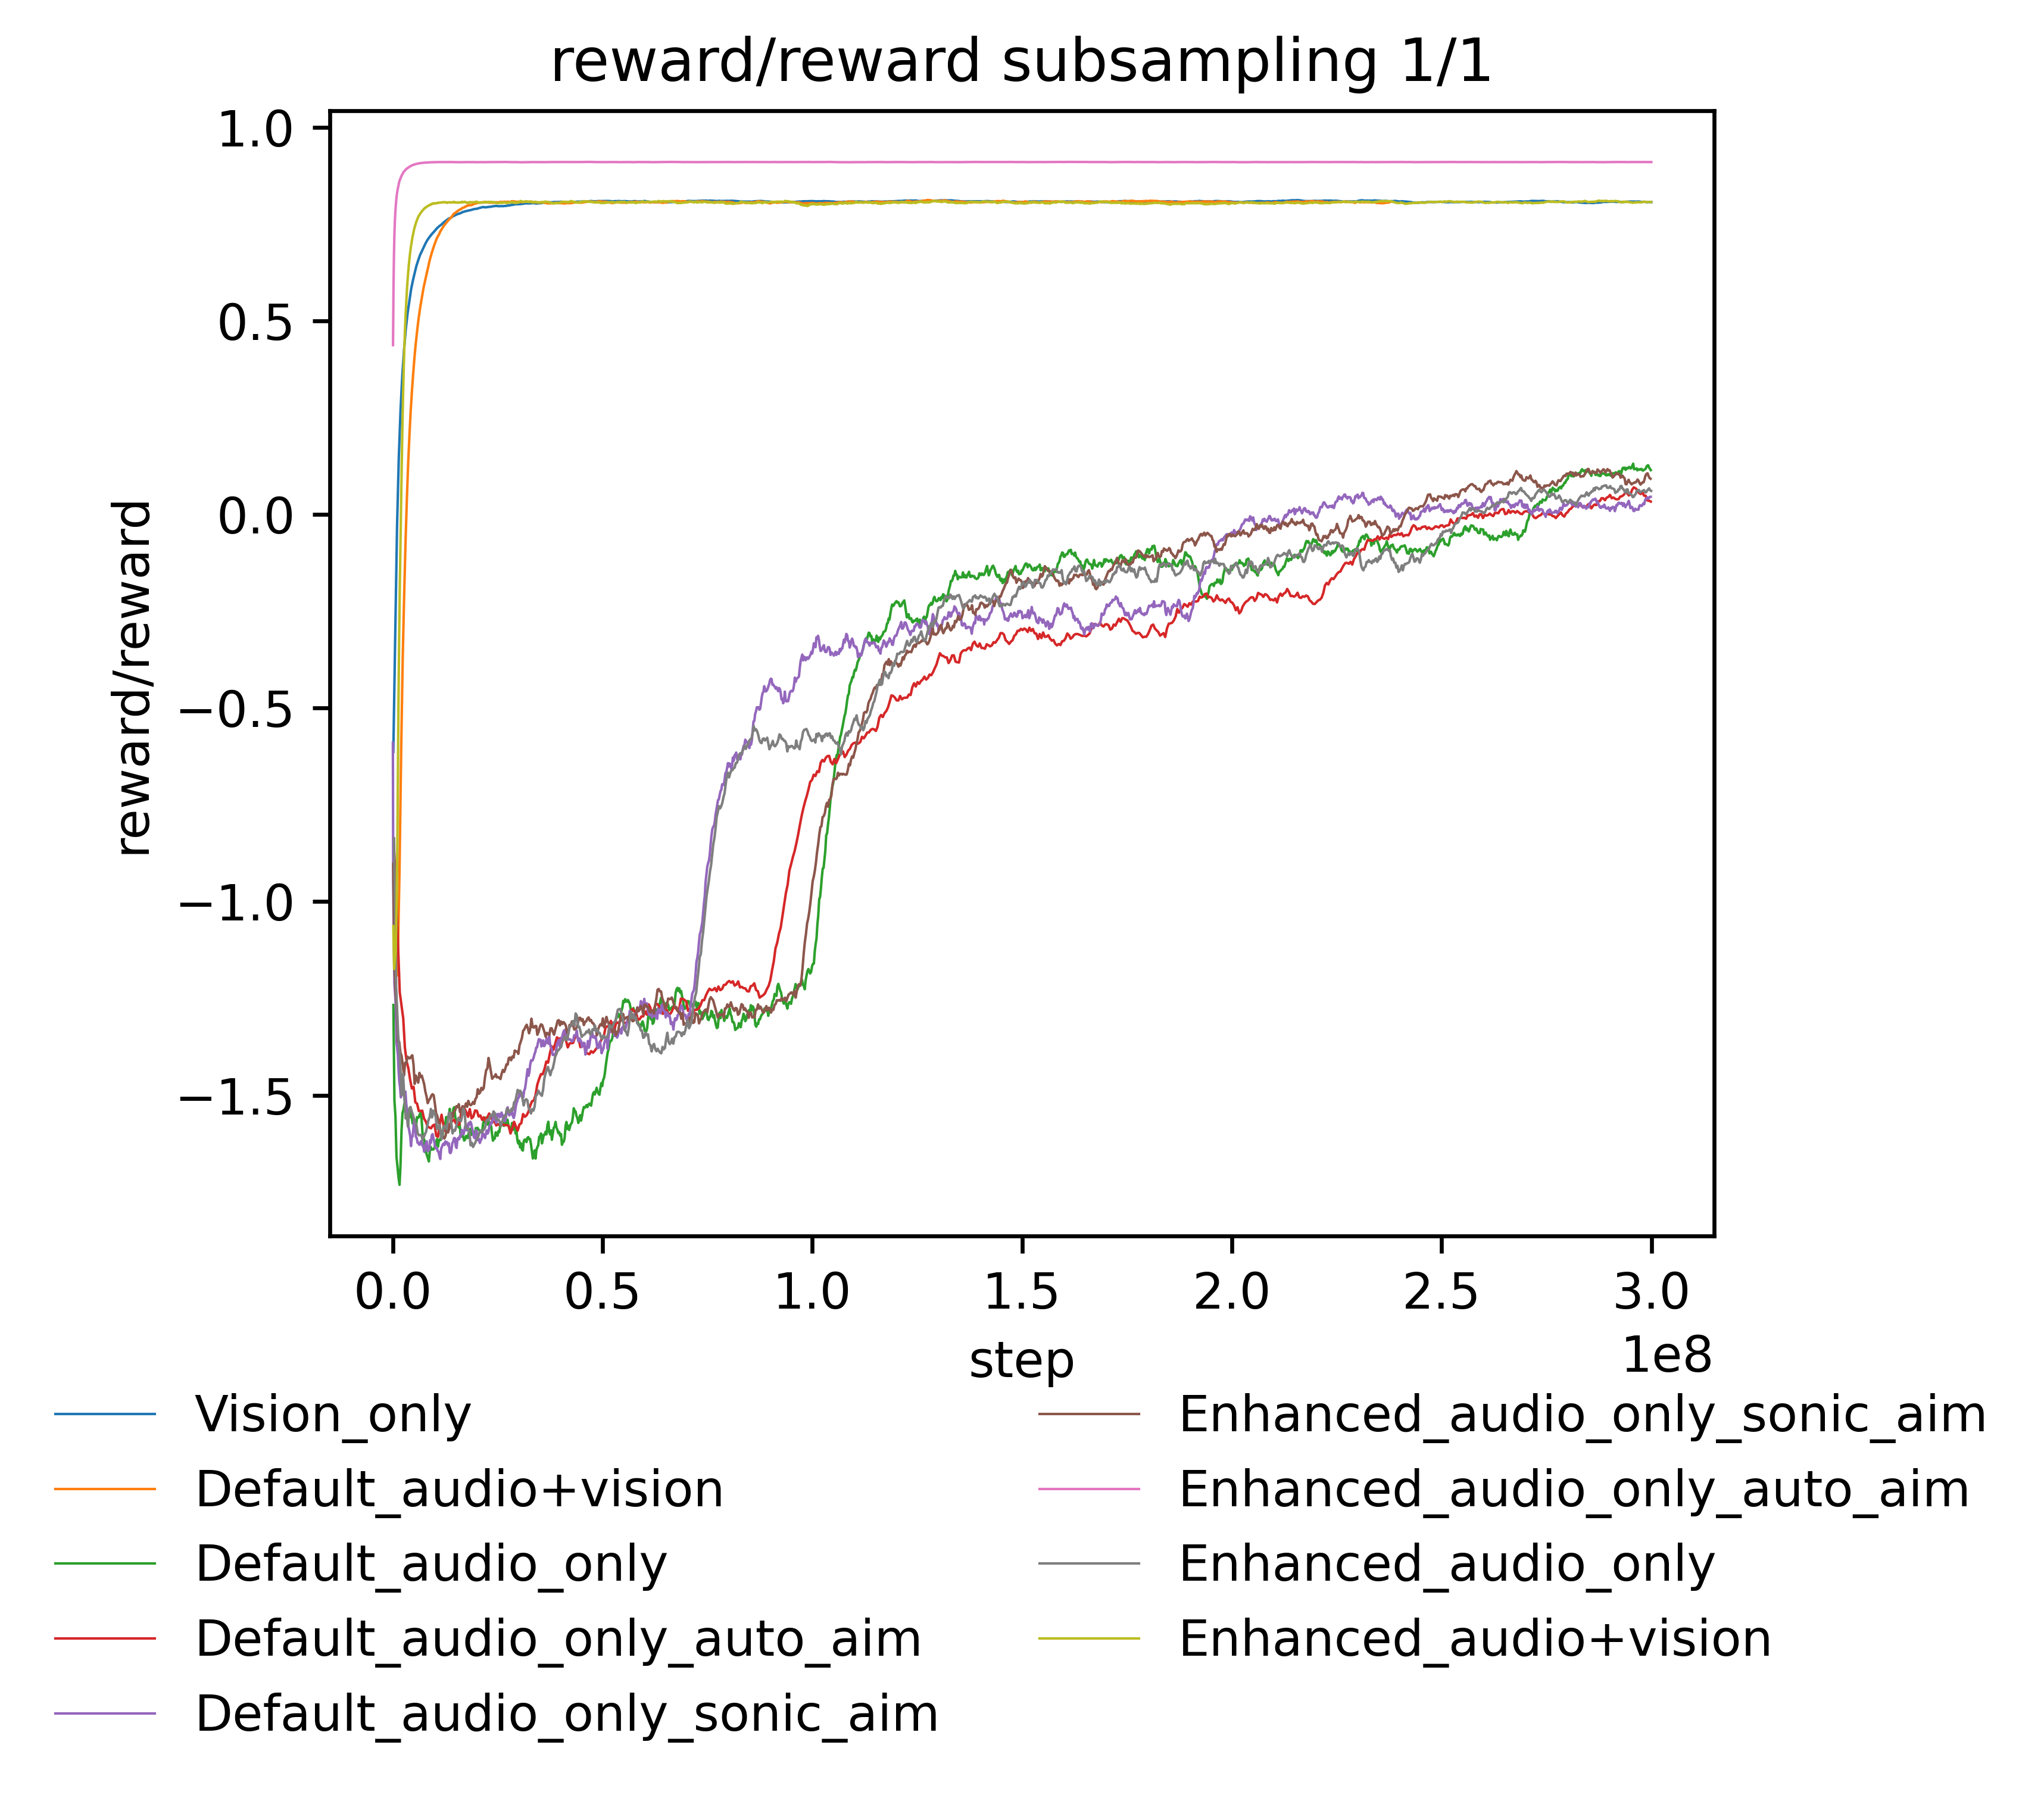

<Figure size 640x480 with 0 Axes>

In [91]:
doom_basic = {
    'Vision_only': df_basic_vision_no_sound,
    'Default_audio+vision': df_basic_vision_fft,
    'Default_audio_only': df_basic_no_vision_fft,
    'Default_audio_only_auto_aim': df_basic_no_vision_fft_auto_aim,
    'Default_audio_only_sonic_aim': df_basic_no_vision_fft_sonic_aim,
    'Enhanced_audio_only_sonic_aim': doom_basic_new_design_no_vision_fft_sonic_aim,
    'Enhanced_audio_only_auto_aim': doom_basic_new_design_no_vision_fft_auto_aim,
    'Enhanced_audio_only': doom_basic_new_design_no_vision_fft,
    'Enhanced_audio+vision': doom_basic_new_design_vision_fft
}
plot(doom_basic, "reward/reward", lim=3e8, smoothing=0.95, subsampling=1)

Enhanced_audio_only


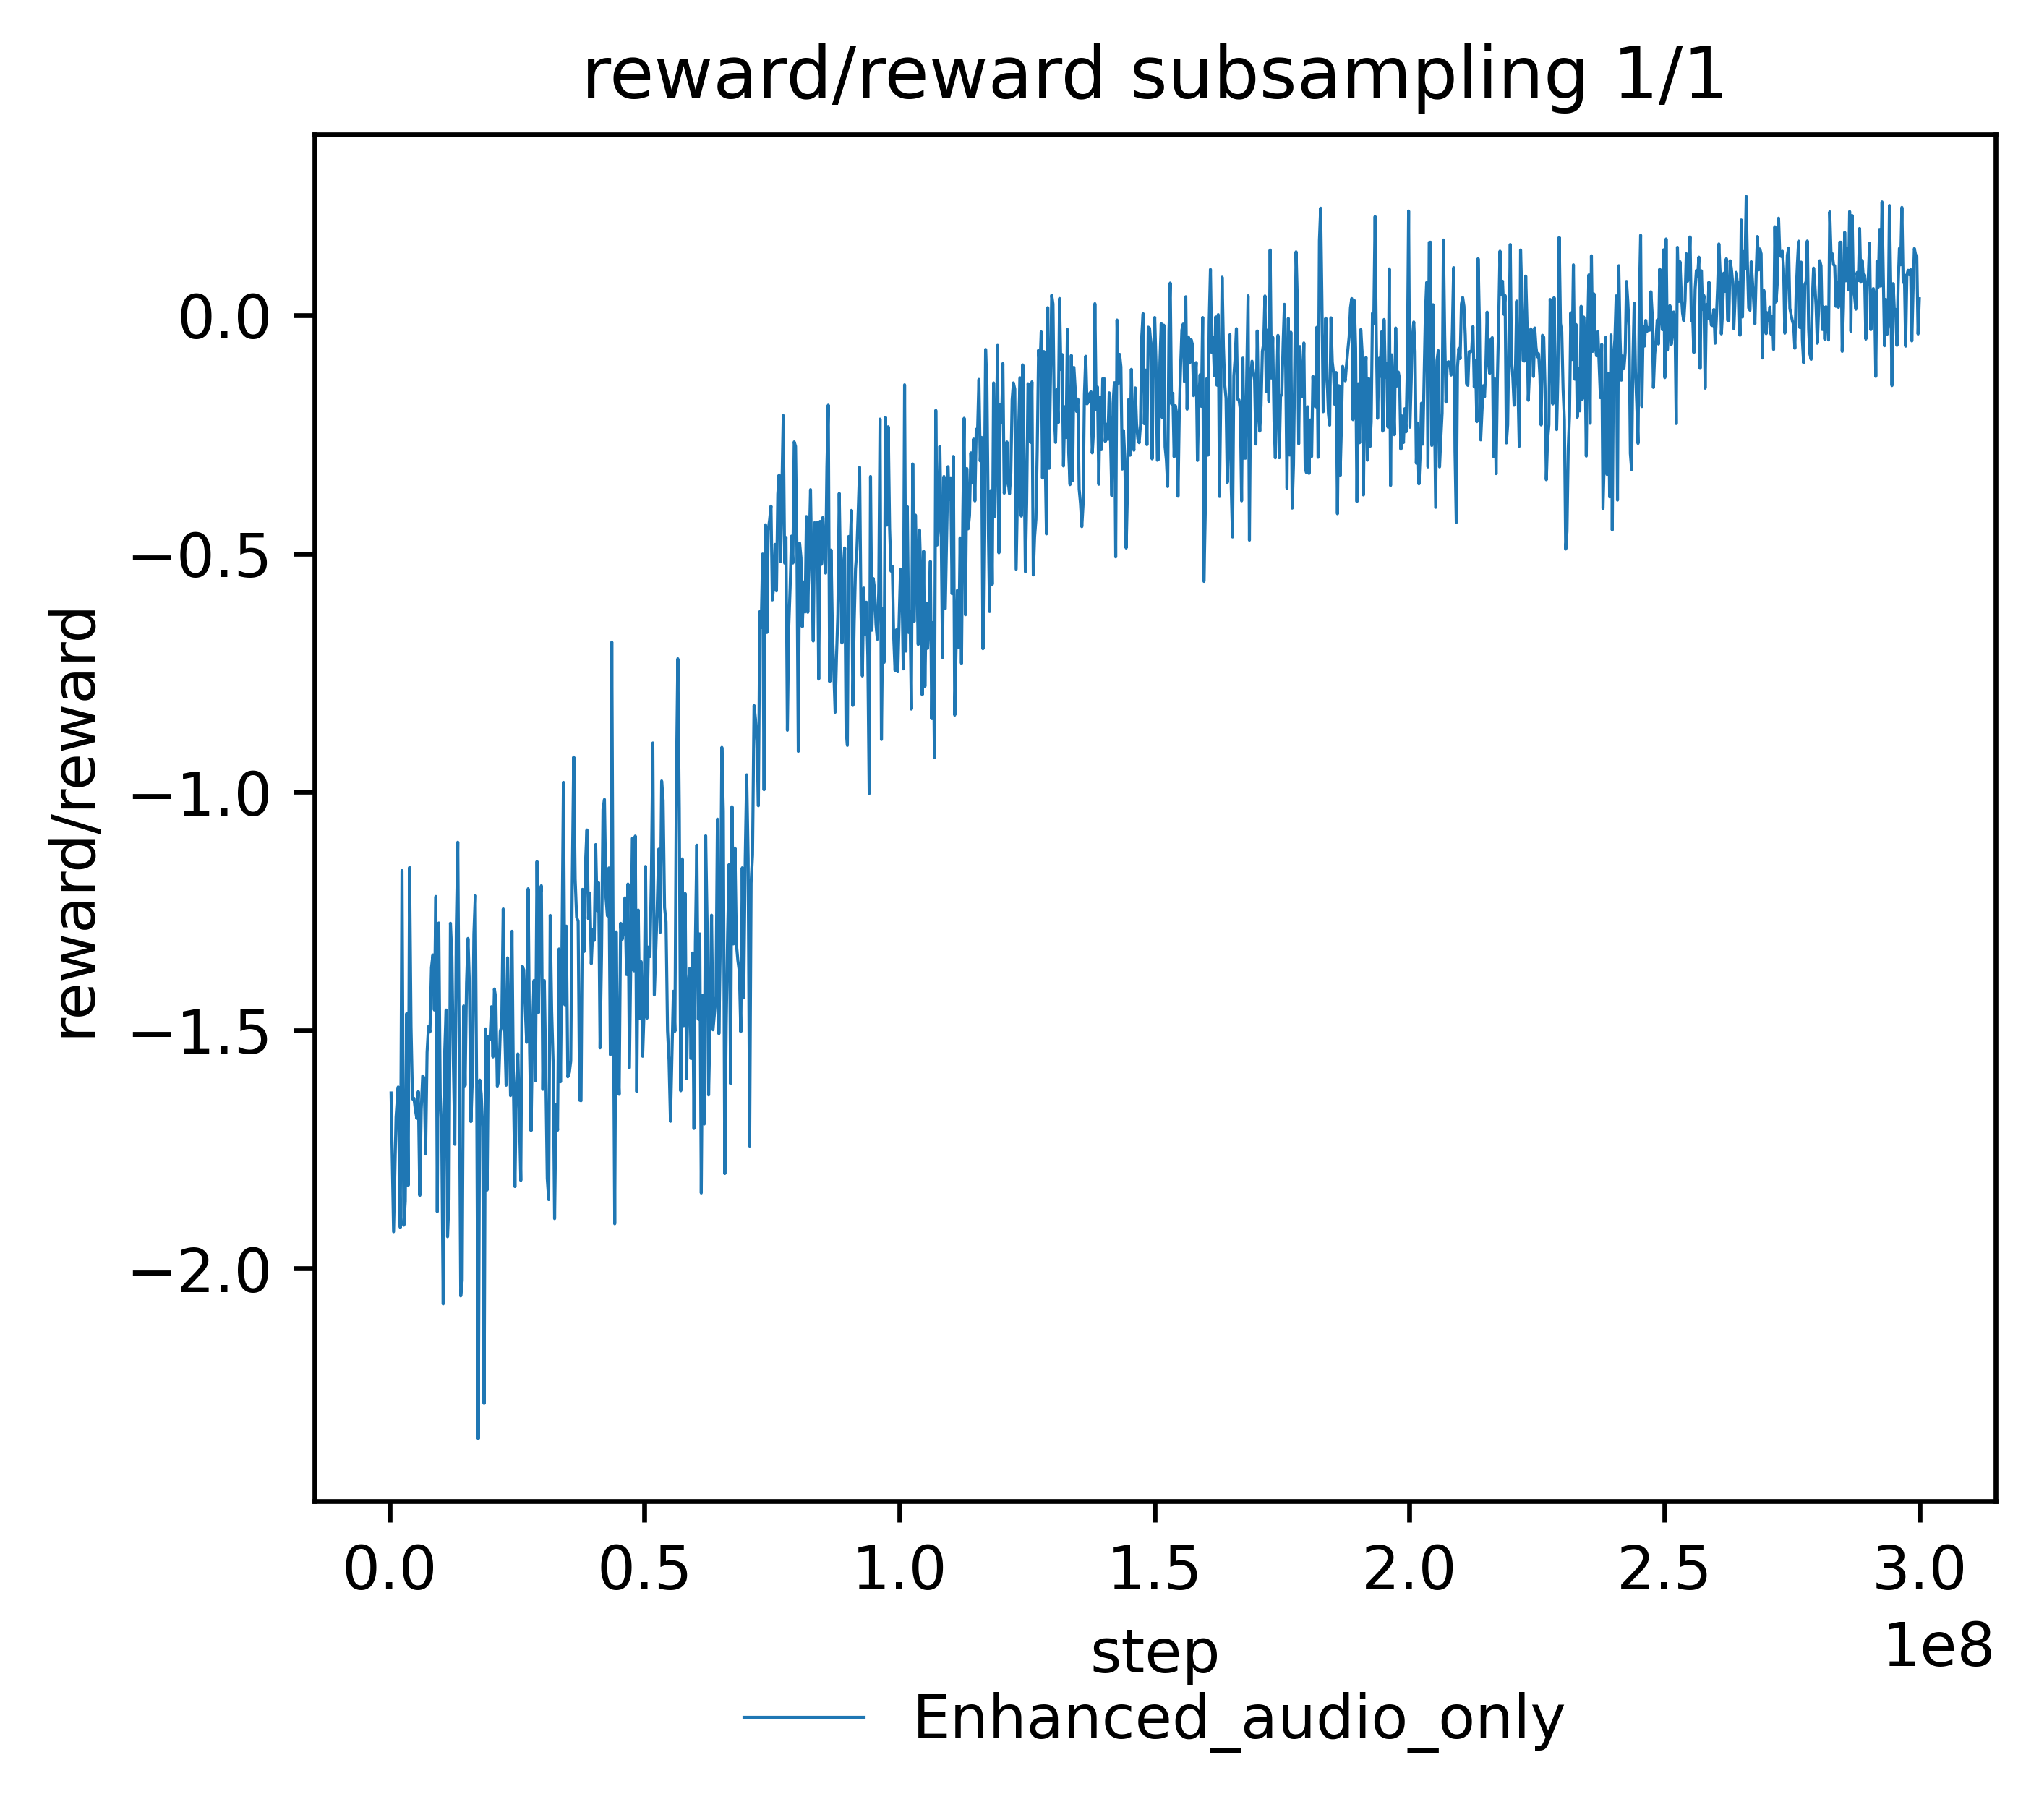

<Figure size 640x480 with 0 Axes>

In [78]:
plot(doom_basic, "reward/reward", lim=3e8, subsampling=1)

basic_default_no_vision_fft
basic_enhanced_no_vision_fft


<Figure size 640x480 with 0 Axes>

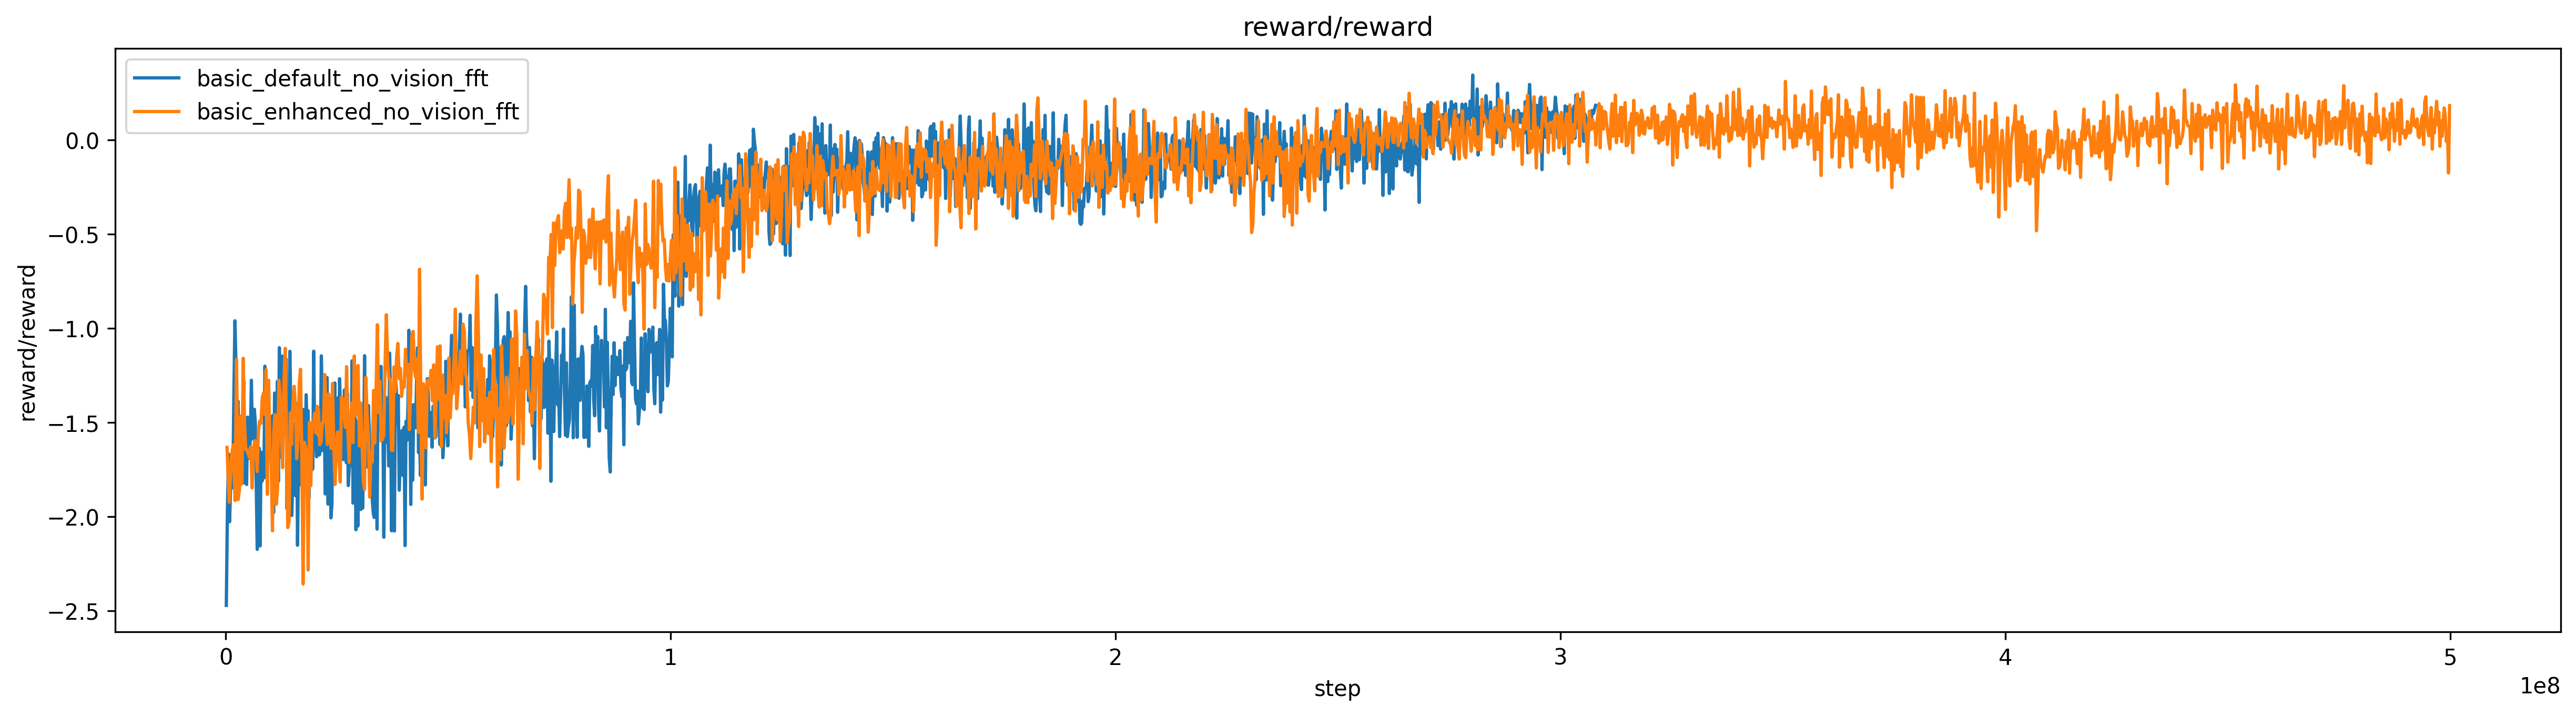

In [59]:
doom_basic = {
    #'basic_vision_only': df_basic_vision_no_sound,
    #'basic_default_vision_fft': df_basic_vision_fft,
    'basic_default_no_vision_fft': df_basic_no_vision_fft,
    #'basic_default_no_vision_fft_auto_aim': df_basic_no_vision_fft_auto_aim,
    #'basic_default_no_vision_fft_sonic_aim': df_basic_no_vision_fft_sonic_aim,
    #'basic_enhanced_no_vision_fft_sonic_aim': doom_basic_new_design_no_vision_fft_sonic_aim,
    #'basic_enhanced_no_vision_fft_auto_aim': doom_basic_new_design_no_vision_fft_auto_aim,
    'basic_enhanced_no_vision_fft': doom_basic_new_design_no_vision_fft,
    #'basic_enhanced_vision_fft': doom_basic_new_design_vision_fft
}
plot(doom_basic, "reward/reward")

doom_deadly_corridor_no_sound
doom_deadly_corridor_no_vision_fft
doom_deadly_corridor_no_vision_fft_sonic_aim
doom_deadly_corridor_no_vision_fft_auto_aim
doom_deadly_corridor_vision_fft
doom_deadly_corridor_new_design_no_vision_fft
doom_deadly_corridor_new_design_no_vision_fft_auto_aim
doom_deadly_corridor_new_design_no_vision_fft_sonic_aim
doom_deadly_corridor_new_design_vision_fft


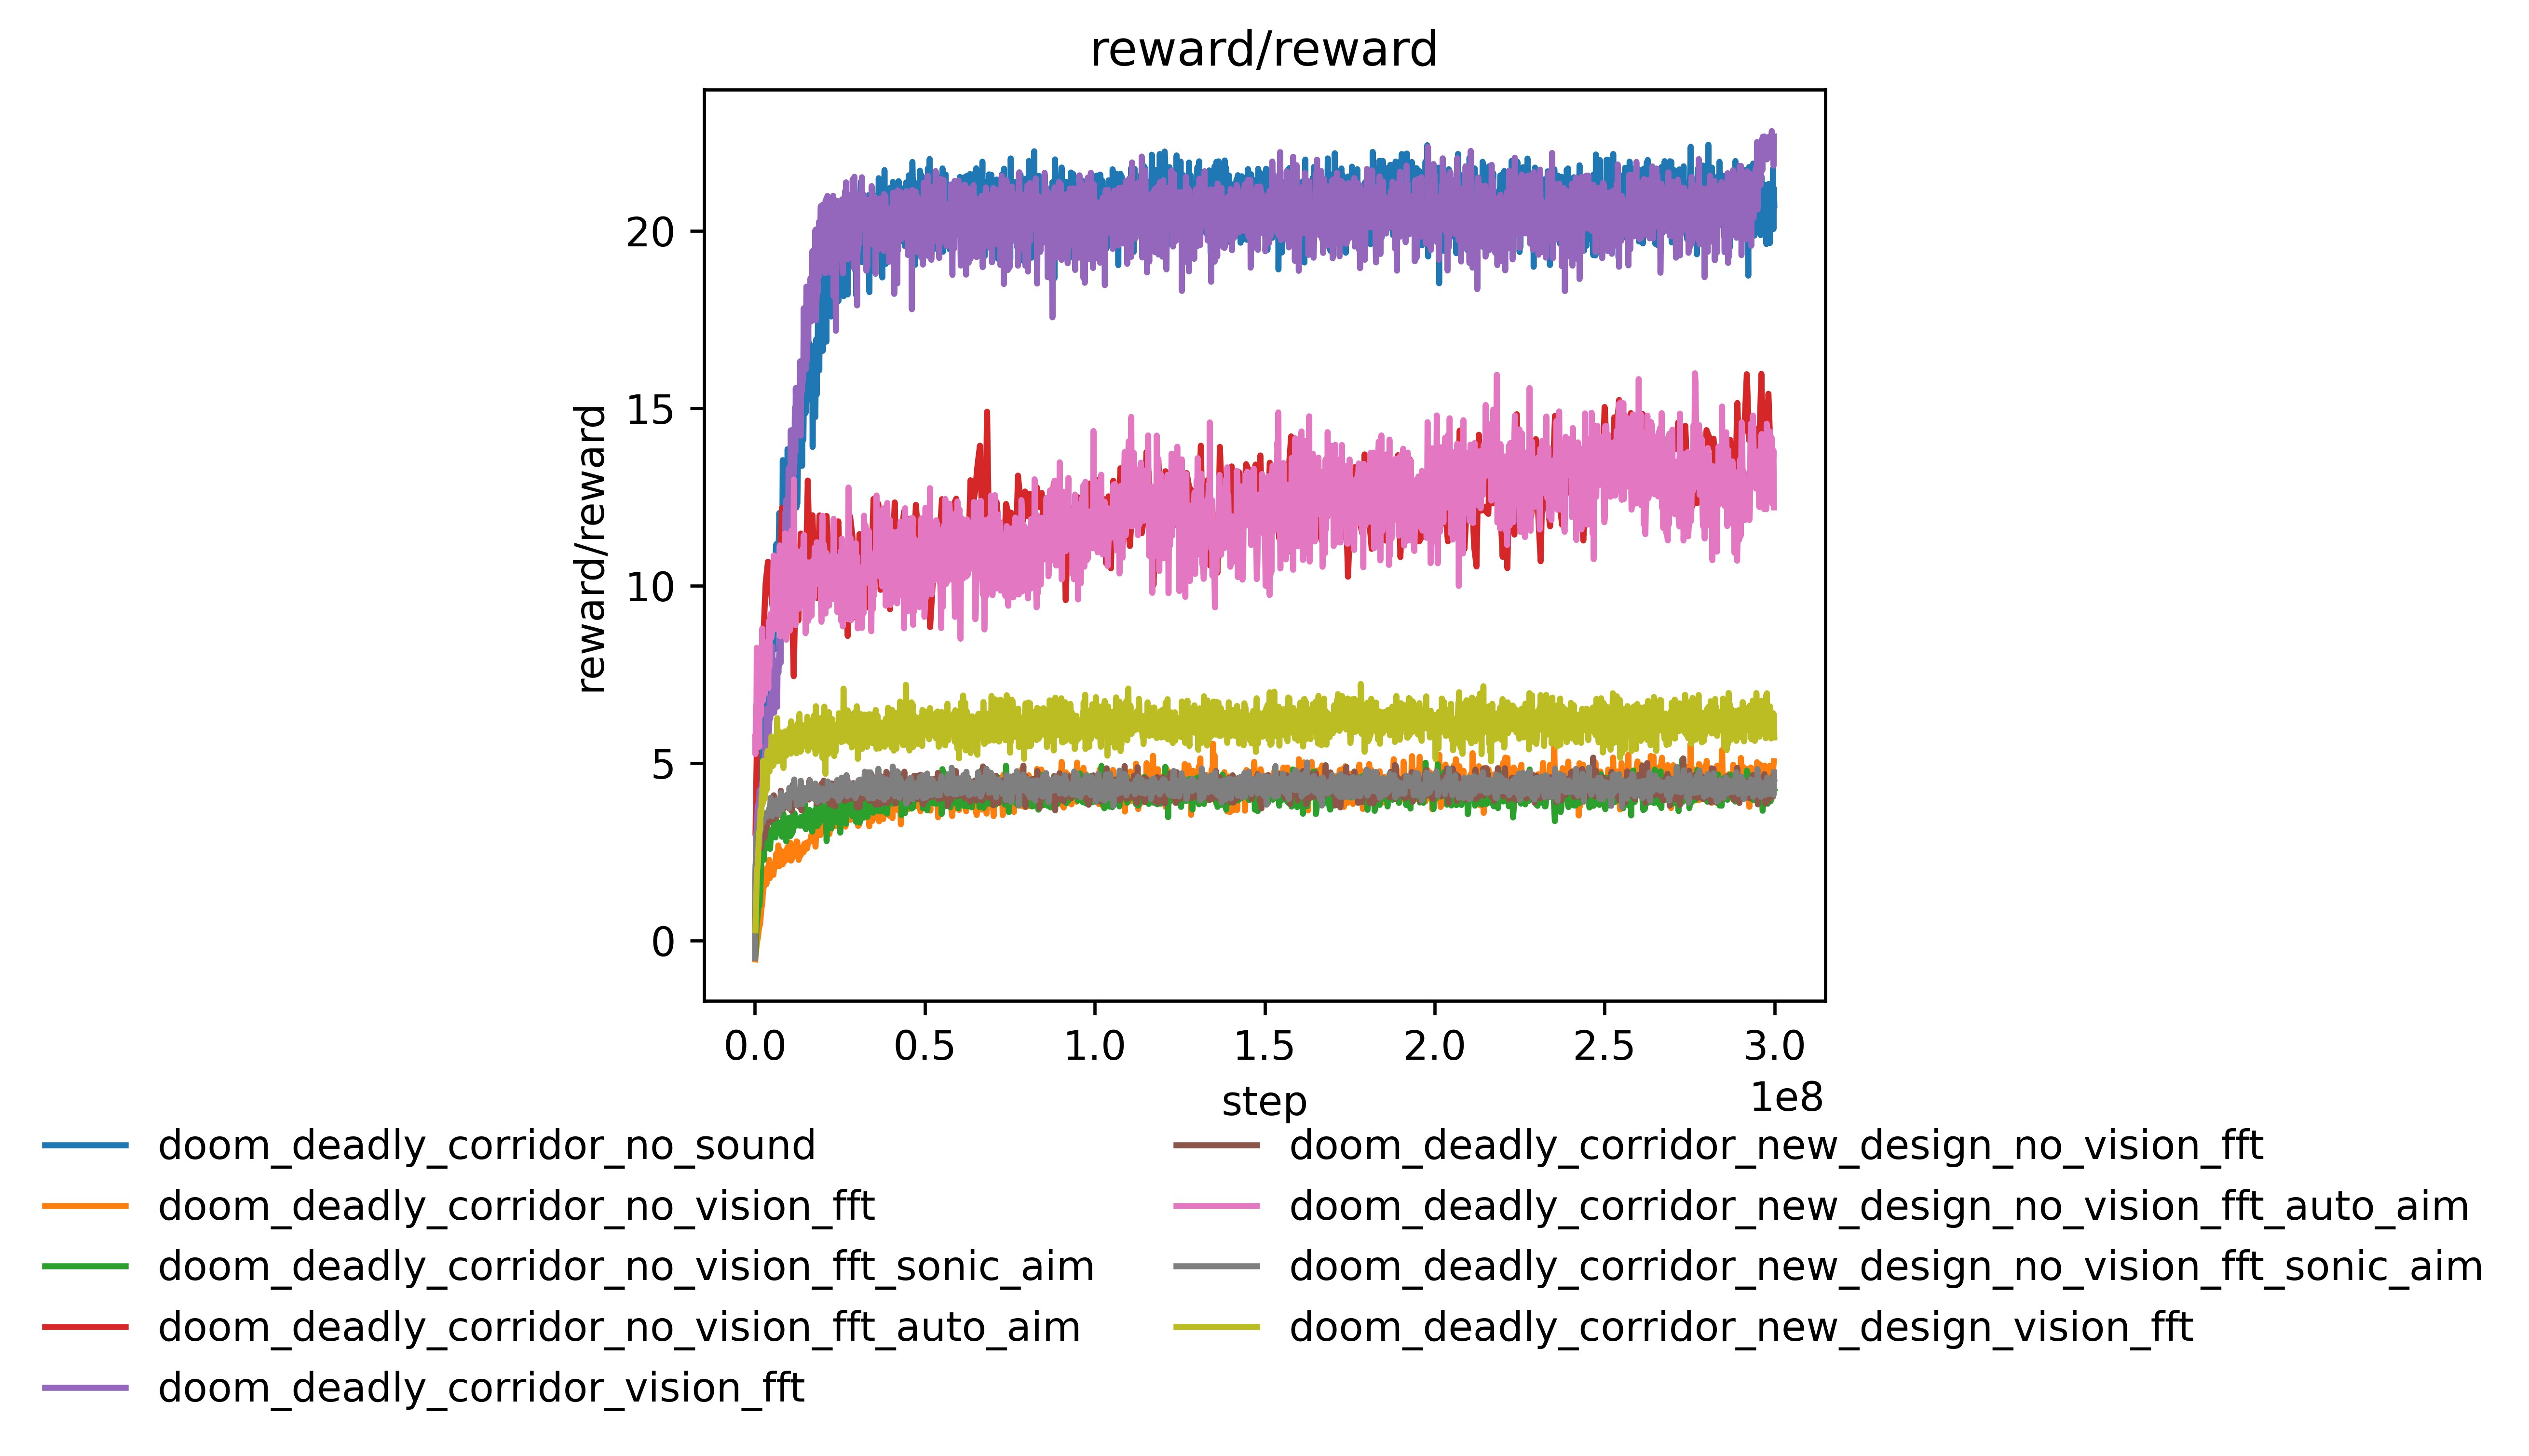

<Figure size 640x480 with 0 Axes>

In [29]:
doom_deadly_corridor_no_sound = tflog2pandas('train_dir_A100/train_dir/doom_deadly_corridor_no_sound/default_experiment/.summary/0/events.out.tfevents.1740719960.DL-Station')
doom_deadly_corridor_no_vision_fft = tflog2pandas('train_dir_A100/train_dir/doom_deadly_corridor_no_vision_fft/default_experiment/.summary/0/events.out.tfevents.1740720031.DL-Station')
doom_deadly_corridor_no_vision_fft_sonic_aim = tflog2pandas('train_dir_A100/train_dir/doom_deadly_corridor_no_vision_fft_sonic_aim/default_experiment/.summary/0/events.out.tfevents.1740917810.DL-Station')
doom_deadly_corridor_no_vision_fft_auto_aim = tflog2pandas('train_dir_a6000/train_dir/doom_deadly_corridor_no_vision_fft_auto_aim/default_experiment/.summary/0/events.out.tfevents.1741552506.localhost-0.tail5e8f5.ts.net')
doom_deadly_corridor_vision_fft = tflog2pandas('train_dir_A100/train_dir/doom_deadly_corridor_vision_fft/default_experiment/.summary/0/events.out.tfevents.1740719989.DL-Station')
doom_deadly_corridor_new_design_no_vision_fft = tflog2pandas('train_dir_a6000/train_dir/doom_deadly_corridor_new_design_no_vision_fft/default_experiment/.summary/0/events.out.tfevents.1741129026.localhost-0.tail5e8f5.ts.net')
doom_deadly_corridor_new_design_no_vision_fft_auto_aim = tflog2pandas('train_dir_a6000/train_dir/doom_deadly_corridor_new_design_no_vision_fft_auto_aim/default_experiment/.summary/0/events.out.tfevents.1741129041.localhost-0.tail5e8f5.ts.net')
doom_deadly_corridor_new_design_no_vision_fft_sonic_aim = tflog2pandas('train_dir_a6000/train_dir/doom_deadly_corridor_new_design_no_vision_fft_sonic_aim/default_experiment/.summary/0/events.out.tfevents.1741129050.localhost-0.tail5e8f5.ts.net')
doom_deadly_corridor_new_design_no_vision_fft_auto_aim = tflog2pandas('train_dir_a6000/train_dir/doom_deadly_corridor_new_design_no_vision_fft_auto_aim/default_experiment/.summary/0/events.out.tfevents.1741129041.localhost-0.tail5e8f5.ts.net')
doom_deadly_corridor_new_design_vision_fft = tflog2pandas('train_dir_a6000/train_dir/doom_deadly_corridor_new_design_vision_fft/default_experiment/.summary/0/events.out.tfevents.1741129012.localhost-0.tail5e8f5.ts.net')
doom_deadly_corridor = {
    'doom_deadly_corridor_no_sound': doom_deadly_corridor_no_sound,
    'doom_deadly_corridor_no_vision_fft': doom_deadly_corridor_no_vision_fft,
    'doom_deadly_corridor_no_vision_fft_sonic_aim': doom_deadly_corridor_no_vision_fft_sonic_aim,
    'doom_deadly_corridor_no_vision_fft_auto_aim': doom_deadly_corridor_no_vision_fft_auto_aim,
    'doom_deadly_corridor_vision_fft': doom_deadly_corridor_vision_fft,
    'doom_deadly_corridor_new_design_no_vision_fft': doom_deadly_corridor_new_design_no_vision_fft,
    'doom_deadly_corridor_new_design_no_vision_fft_auto_aim': doom_deadly_corridor_new_design_no_vision_fft_auto_aim,
    'doom_deadly_corridor_new_design_no_vision_fft_sonic_aim': doom_deadly_corridor_new_design_no_vision_fft_sonic_aim,
    'doom_deadly_corridor_new_design_vision_fft': doom_deadly_corridor_new_design_vision_fft
}
plot(doom_deadly_corridor, "reward/reward", lim=3e8, smoothing=0.6)

Vision_only
perform smoothing
Default_audio_only
perform smoothing
Default_audio_only_sonic_aim
perform smoothing
Default_audio_only_auto_aim
perform smoothing
Default_audio+vision
perform smoothing
Enhanced_audio_only
perform smoothing
Enhanced_audio_only_auto_aim
perform smoothing
Enhanced_audio_only_sonic_aim
perform smoothing
Enhanced_audio+vision
perform smoothing


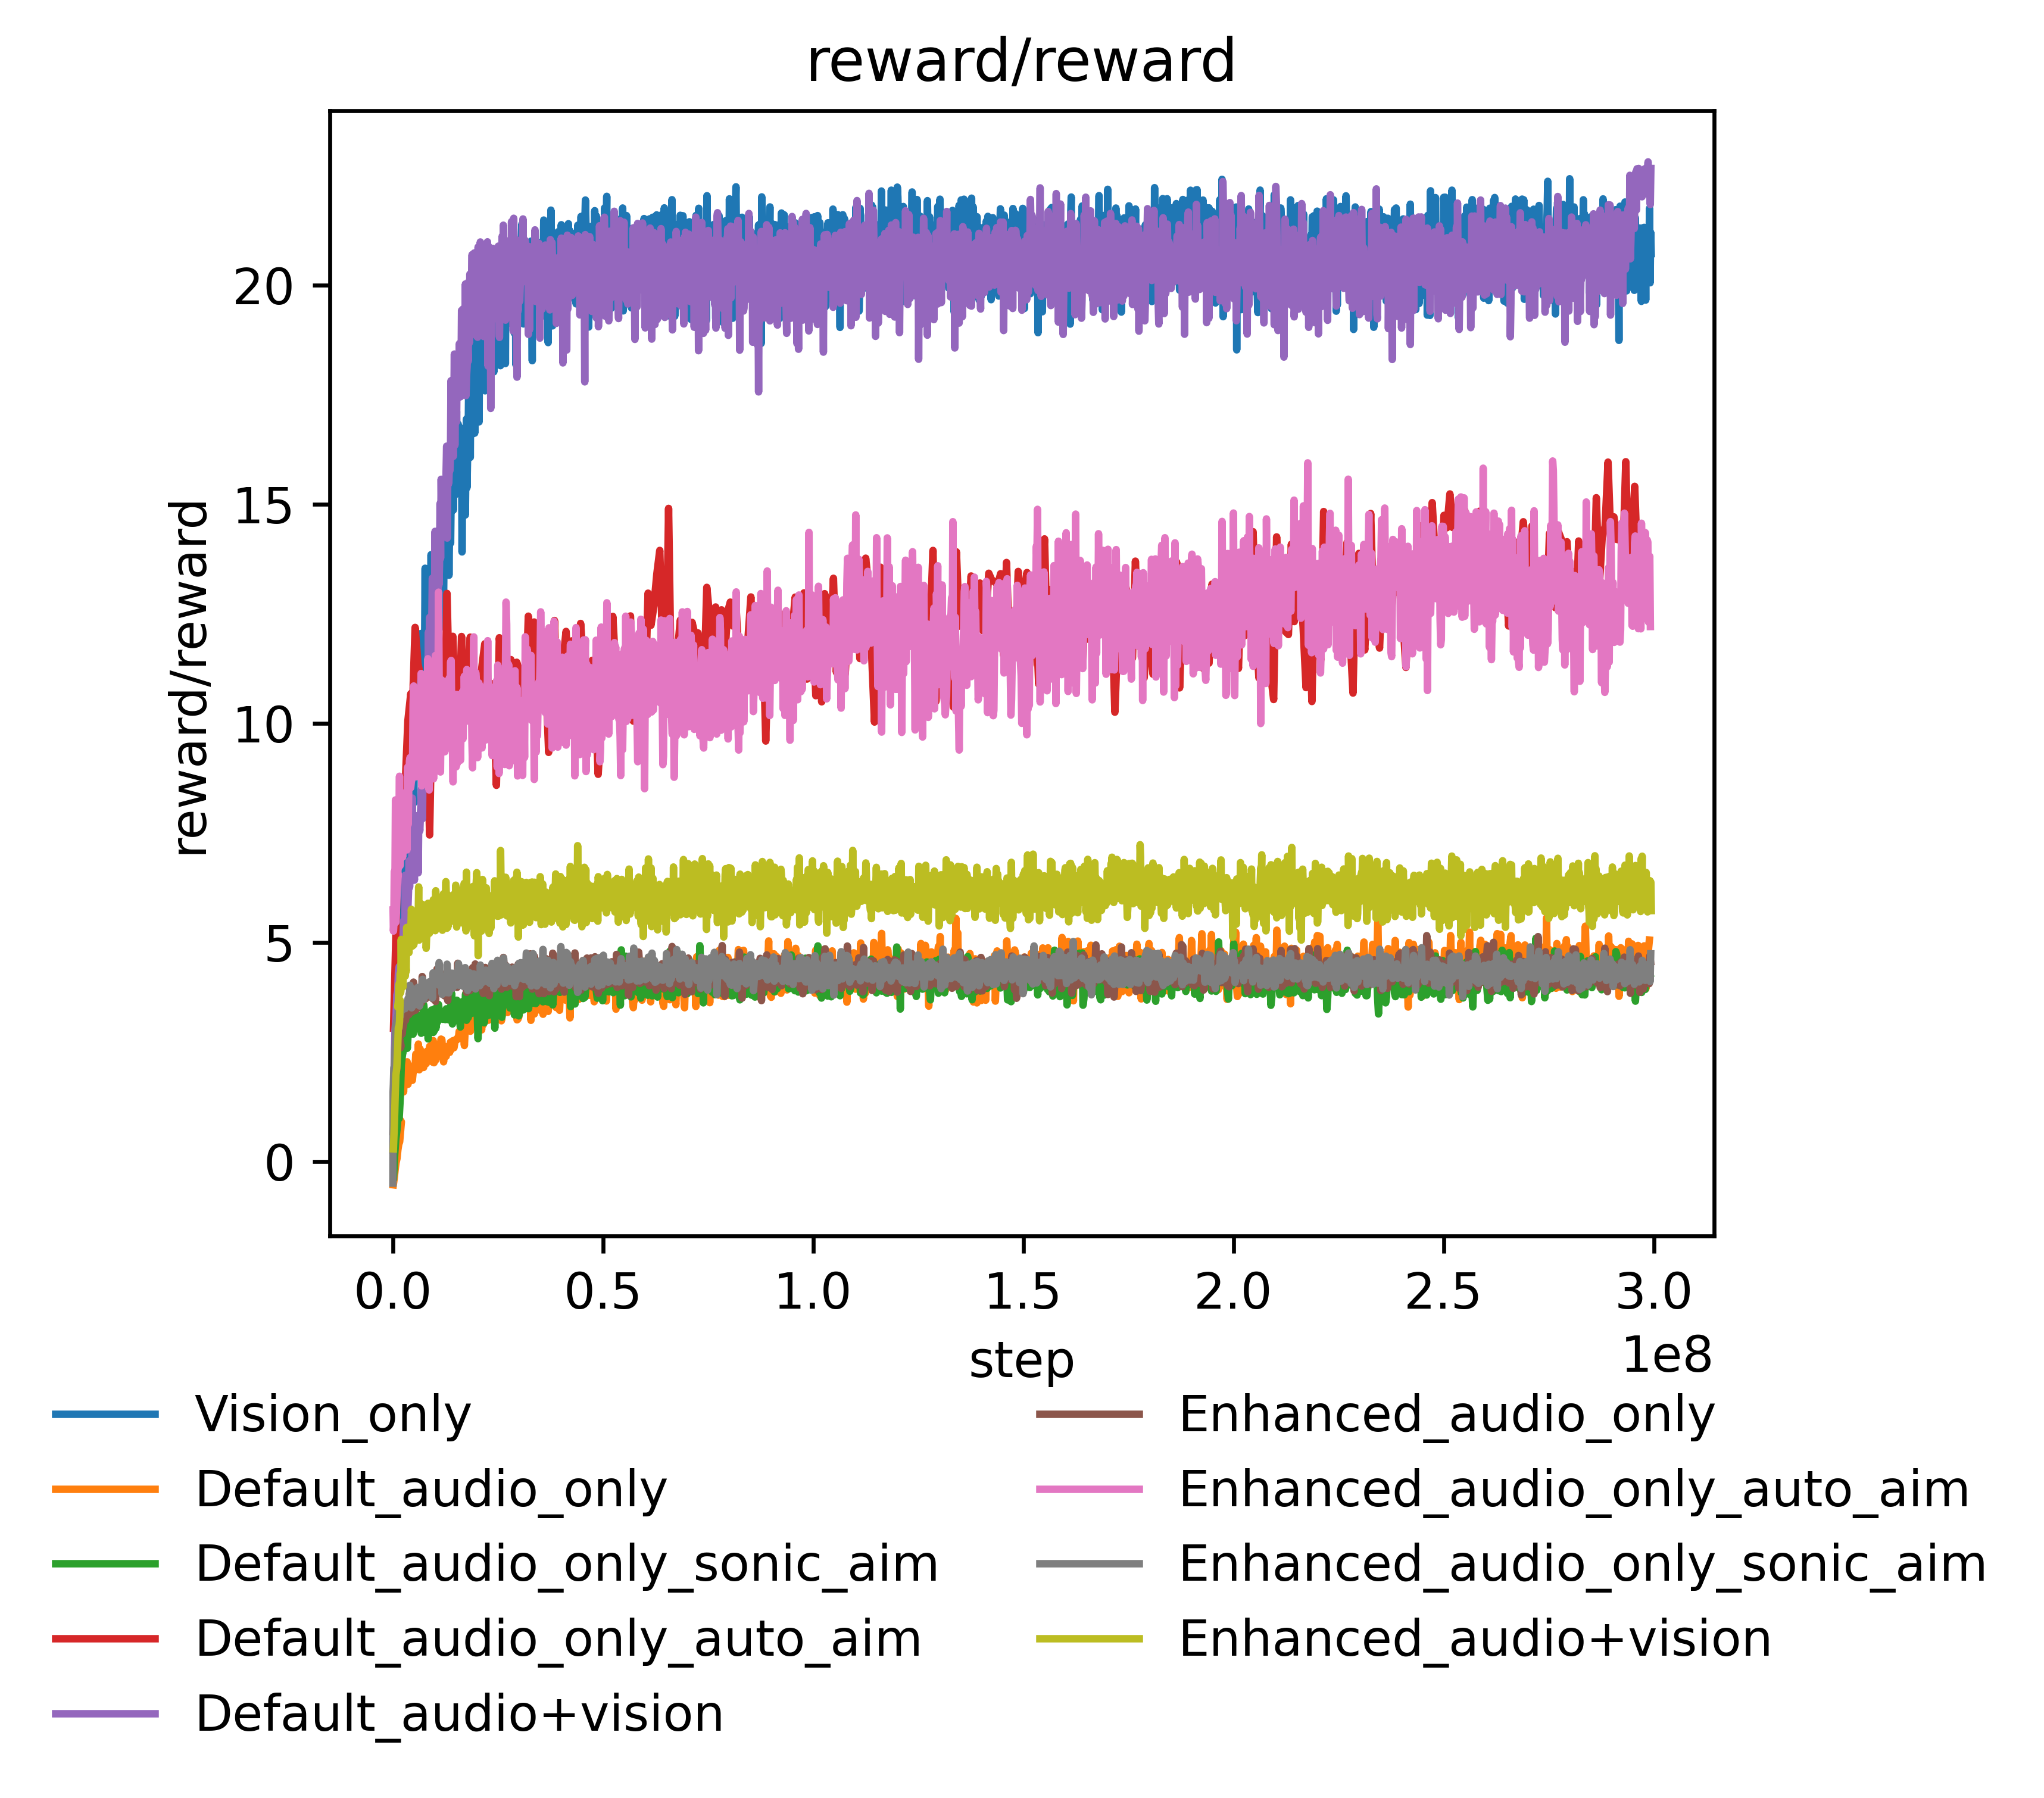

<Figure size 640x480 with 0 Axes>

In [19]:
doom_deadly_corridor = {
    'Vision_only': doom_deadly_corridor_no_sound,
    'Default_audio_only': doom_deadly_corridor_no_vision_fft,
    'Default_audio_only_sonic_aim': doom_deadly_corridor_no_vision_fft_sonic_aim,
    'Default_audio_only_auto_aim': doom_deadly_corridor_no_vision_fft_auto_aim,
    'Default_audio+vision': doom_deadly_corridor_vision_fft,
    'Enhanced_audio_only': doom_deadly_corridor_new_design_no_vision_fft,
    'Enhanced_audio_only_auto_aim': doom_deadly_corridor_new_design_no_vision_fft_auto_aim,
    'Enhanced_audio_only_sonic_aim': doom_deadly_corridor_new_design_no_vision_fft_sonic_aim,
    'Enhanced_audio+vision': doom_deadly_corridor_new_design_vision_fft
}
plot(doom_deadly_corridor, "reward/reward", lim=3e8, smoothing=10, subsampling=0)

doom_my_way_home_no_sound
doom_my_way_home_vision_fft
doom_my_way_home_no_vision_fft
doom_my_way_home_no_vision_fft_auto_aim
doom_my_way_home_no_vision_fft_sonic_aim
doom_my_way_home_new_design_vision_fft
doom_my_way_home_new_design_no_vision_fft
doom_my_way_home_new_design_no_vision_fft_auto_aim
doom_my_way_home_new_design_no_vision_fft_sonic_aim


<Figure size 640x480 with 0 Axes>

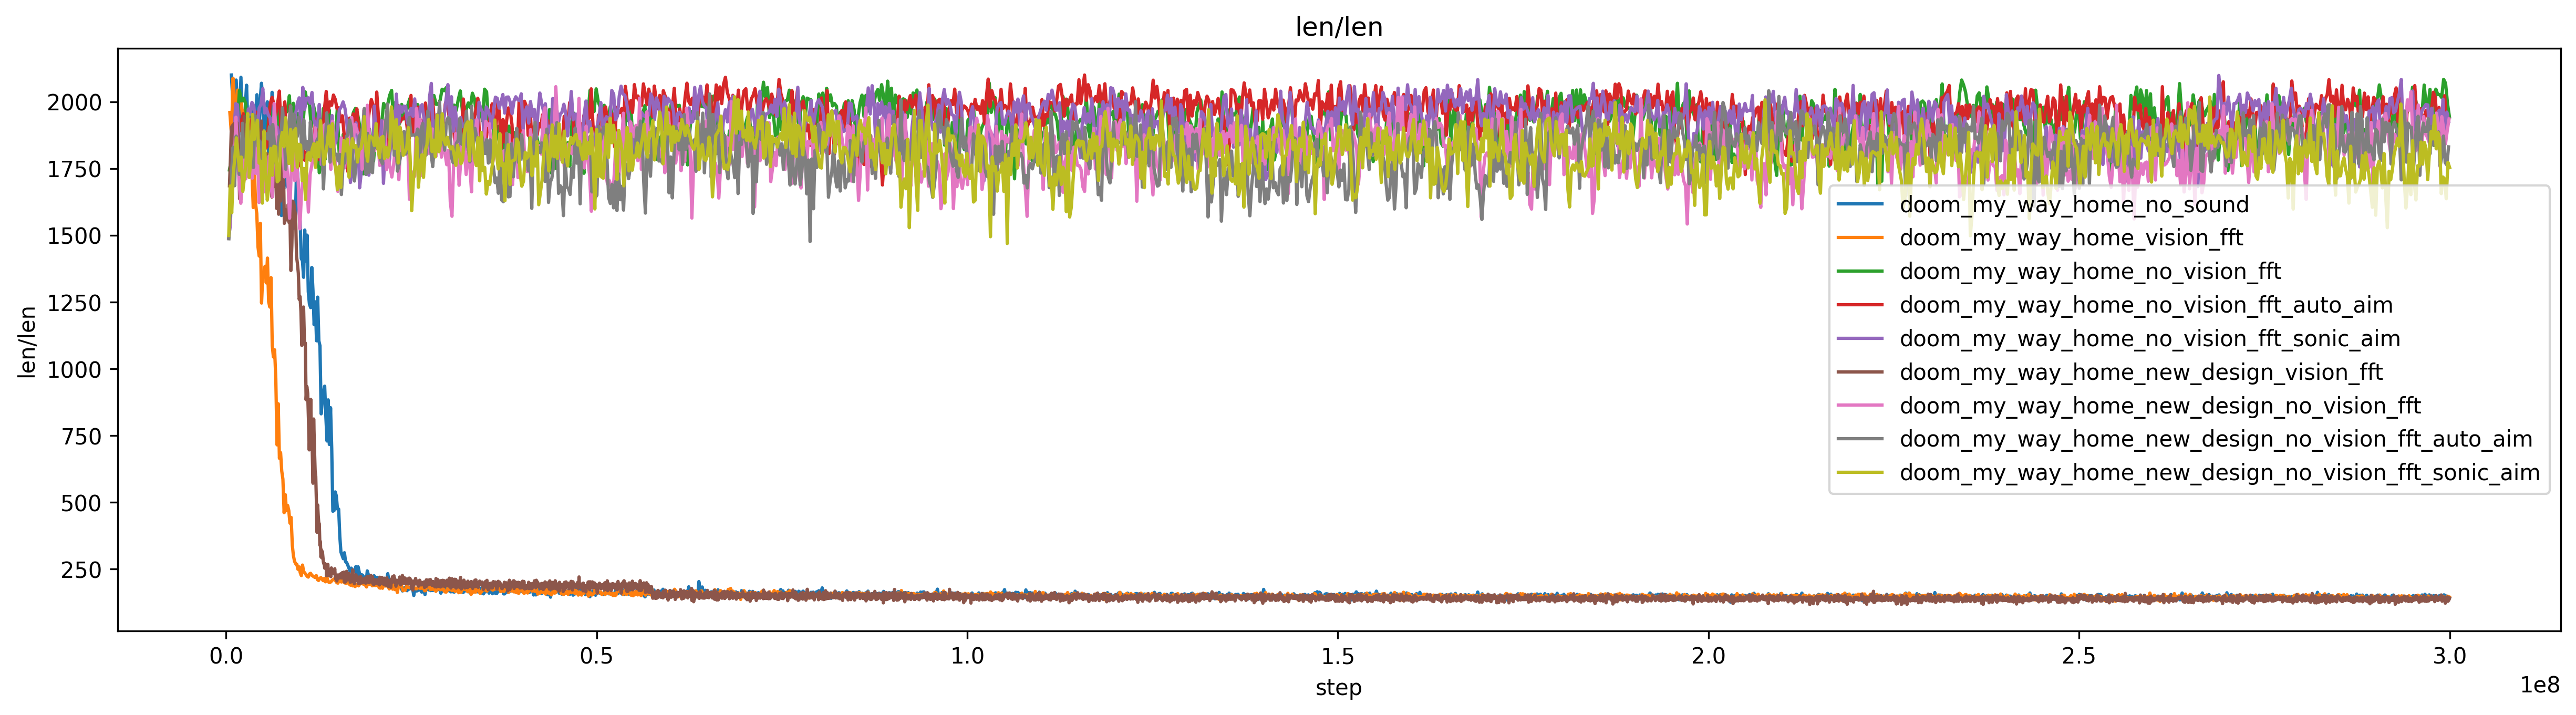

In [51]:
doom_my_way_home_no_sound = tflog2pandas('train_dir_A100/train_dir/doom_my_way_home_no_sound/default_experiment/.summary/0/events.out.tfevents.1740918005.DL-Station')
doom_my_way_home_vision_fft = tflog2pandas('train_dir_A100/train_dir/doom_my_way_home_vision_fft/default_experiment/.summary/0/events.out.tfevents.1740918028.DL-Station')
doom_my_way_home_no_vision_fft = tflog2pandas('train_dir_A100/train_dir/doom_my_way_home_no_vision_fft/default_experiment/.summary/0/events.out.tfevents.1740918037.DL-Station')
doom_my_way_home_no_vision_fft_auto_aim = tflog2pandas('train_dir_A100/train_dir/doom_my_way_home_no_vision_fft_auto_aim/default_experiment/.summary/0/events.out.tfevents.1740918046.DL-Station')
doom_my_way_home_no_vision_fft_sonic_aim = tflog2pandas('train_dir_A100/train_dir/doom_my_way_home_no_vision_fft_sonic_aim/default_experiment/.summary/0/events.out.tfevents.1740918054.DL-Station')

doom_my_way_home_new_design_vision_fft = tflog2pandas(['train_dir_A100/train_dir/doom_my_way_home_new_design_vision_fft/default_experiment/.summary/0/events.out.tfevents.1741198522.DL-Station', 'train_dir_A100/train_dir/doom_my_way_home_new_design_vision_fft/default_experiment/.summary/0/events.out.tfevents.1741222010.DL-Station'])
doom_my_way_home_new_design_no_vision_fft = tflog2pandas('train_dir_A100/train_dir/doom_my_way_home_new_design_no_vision_fft/default_experiment/.summary/0/events.out.tfevents.1741198532.DL-Station')
doom_my_way_home_new_design_no_vision_fft_auto_aim = tflog2pandas('train_dir_A100/train_dir/doom_my_way_home_new_design_no_vision_fft_auto_aim/default_experiment/.summary/0/events.out.tfevents.1741198536.DL-Station')
doom_my_way_home_new_design_no_vision_fft_sonic_aim= tflog2pandas('train_dir_A100/train_dir/doom_my_way_home_new_design_no_vision_fft_sonic_aim/default_experiment/.summary/0/events.out.tfevents.1741198540.DL-Station')
doom_my_way_home = {
    'doom_my_way_home_no_sound': doom_my_way_home_no_sound,
    'doom_my_way_home_vision_fft': doom_my_way_home_vision_fft,
    'doom_my_way_home_no_vision_fft': doom_my_way_home_no_vision_fft,
    'doom_my_way_home_no_vision_fft_auto_aim': doom_my_way_home_no_vision_fft_auto_aim,
    'doom_my_way_home_no_vision_fft_sonic_aim': doom_my_way_home_no_vision_fft_sonic_aim,
    'doom_my_way_home_new_design_vision_fft': doom_my_way_home_new_design_vision_fft,
    'doom_my_way_home_new_design_no_vision_fft': doom_my_way_home_new_design_no_vision_fft,
    'doom_my_way_home_new_design_no_vision_fft_auto_aim': doom_my_way_home_new_design_no_vision_fft_auto_aim,
    'doom_my_way_home_new_design_no_vision_fft_sonic_aim': doom_my_way_home_new_design_no_vision_fft_sonic_aim
}
plot(doom_my_way_home, "len/len", lim=3e8)

Default_audio_only
Enhanced_audio_only


<Figure size 640x480 with 0 Axes>

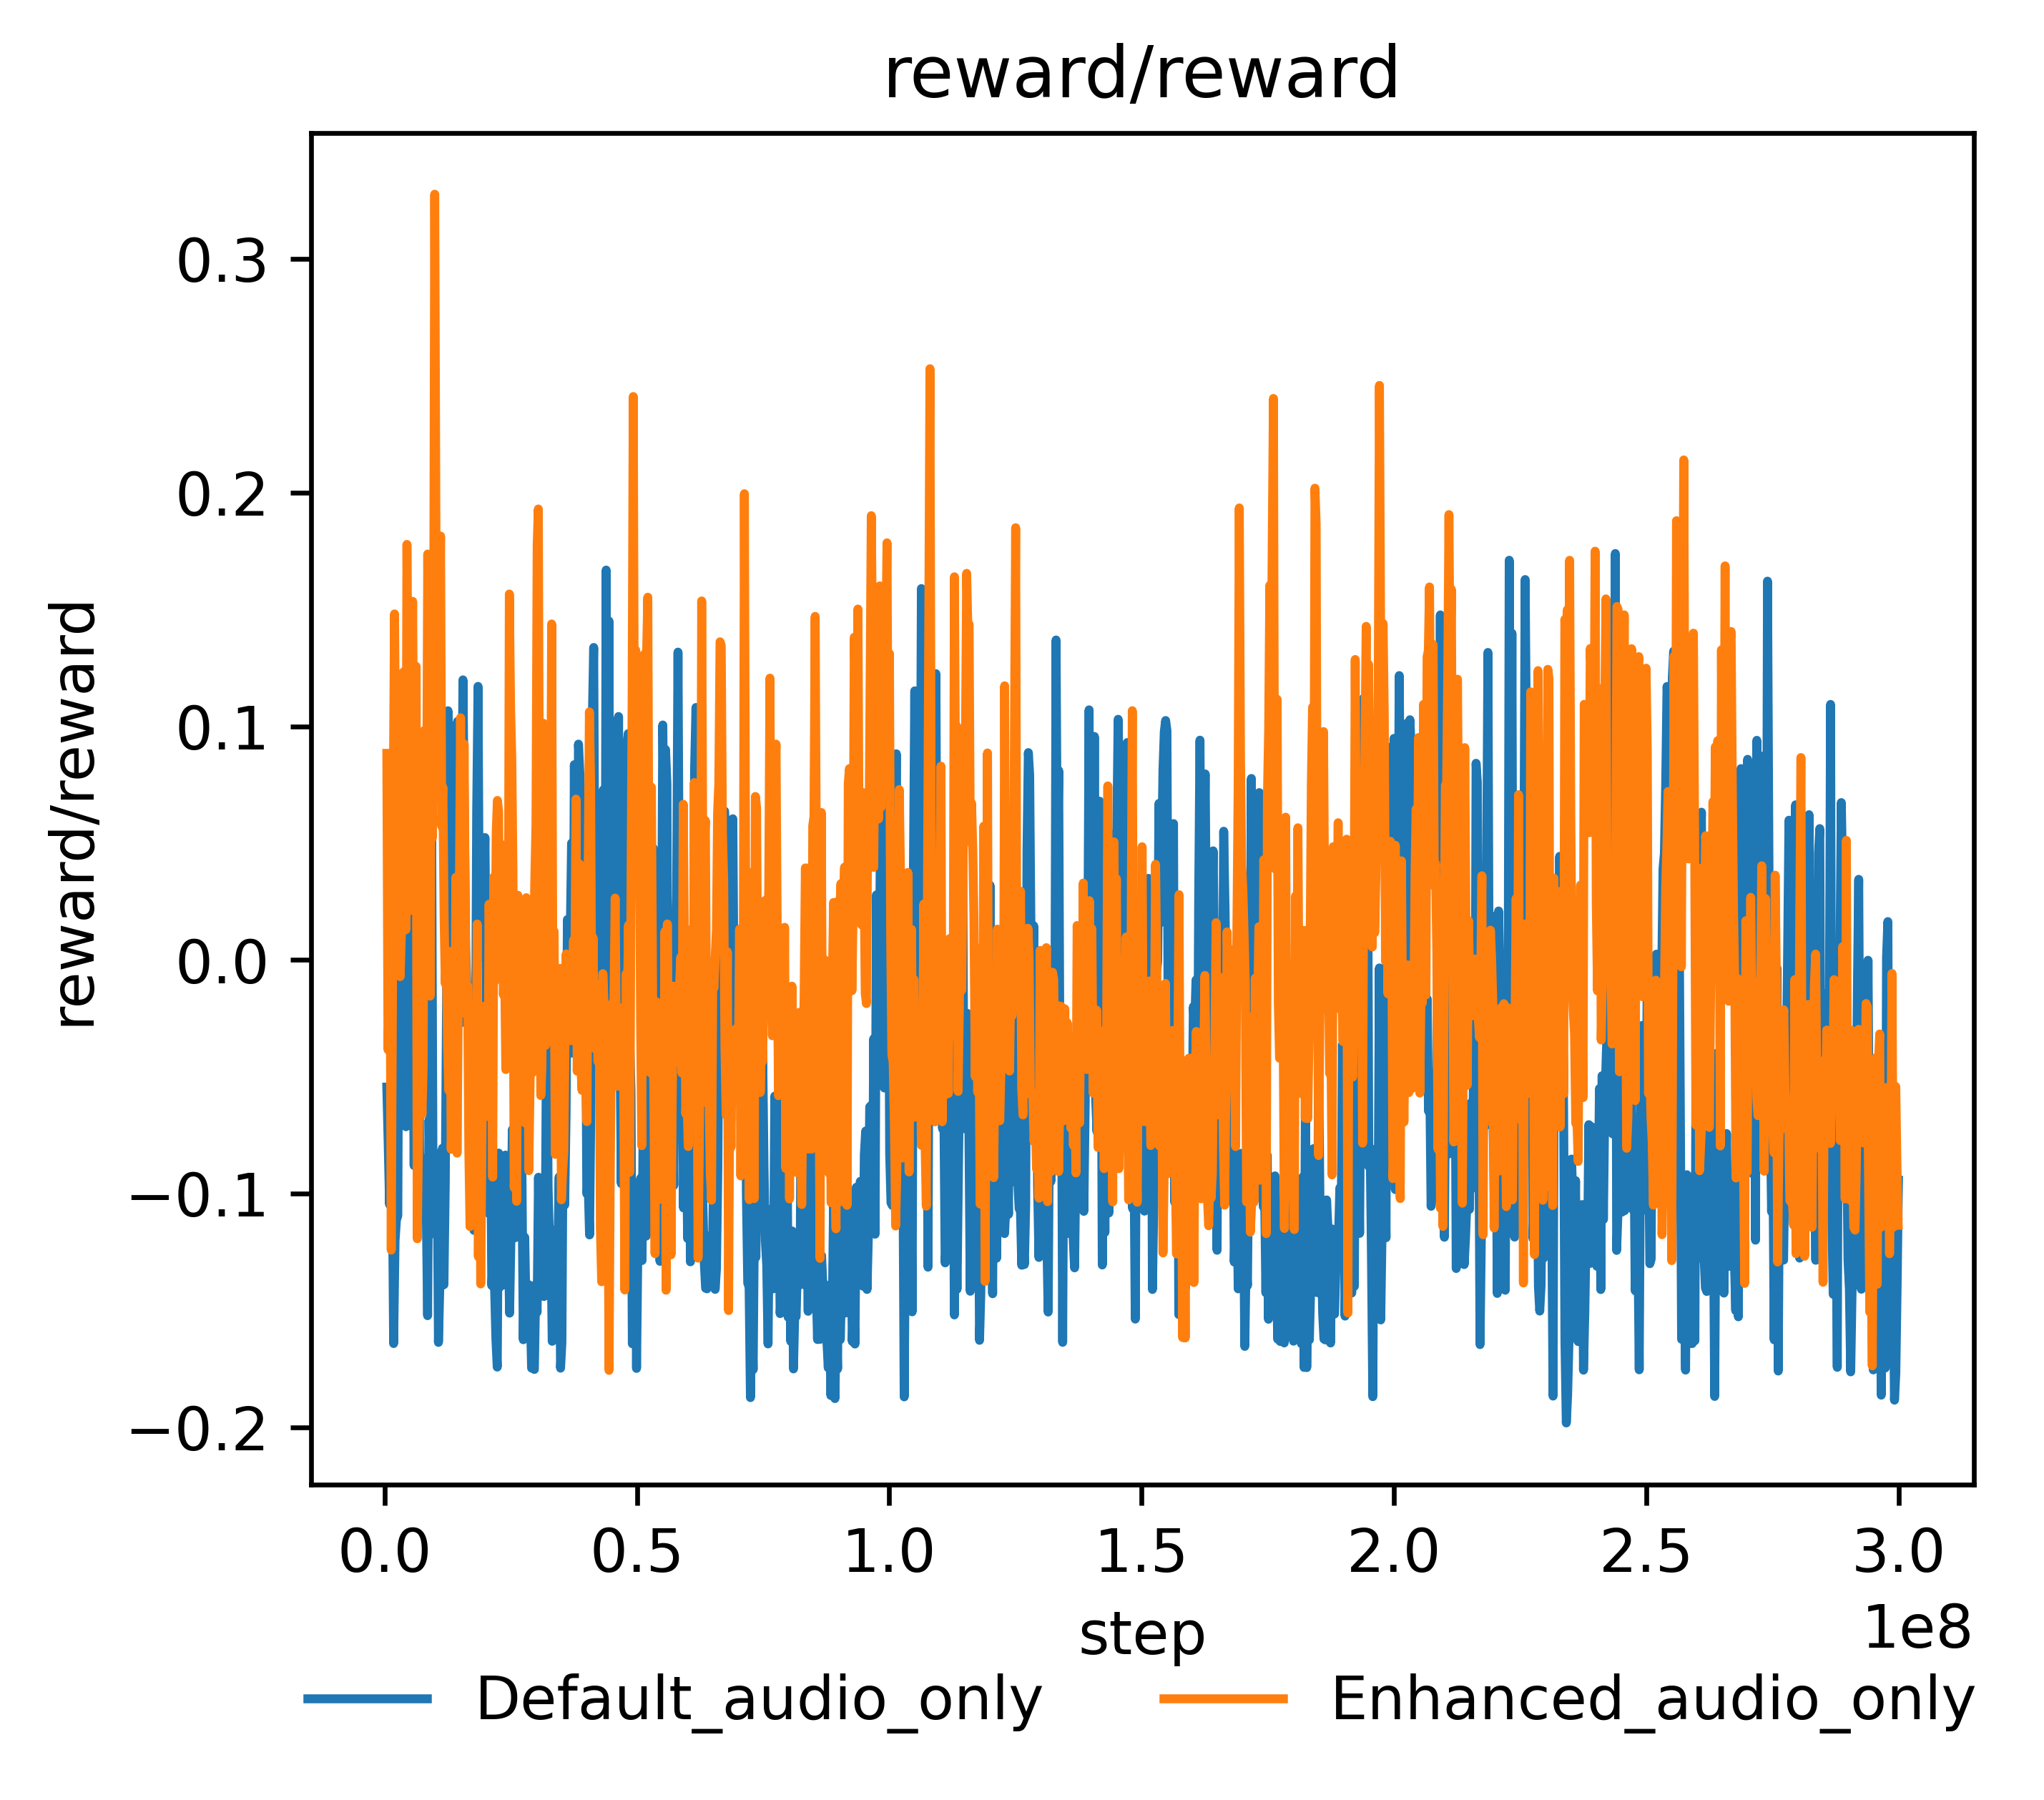

In [102]:
doom_my_way_home = {
    #'Vision_only': doom_my_way_home_no_sound,
    #'Default_audio+vision': doom_my_way_home_vision_fft,
    'Default_audio_only': doom_my_way_home_no_vision_fft,
    #'doom_my_way_home_no_vision_fft_auto_aim': doom_my_way_home_no_vision_fft_auto_aim,
    #'doom_my_way_home_no_vision_fft_sonic_aim': doom_my_way_home_no_vision_fft_sonic_aim,
    #'Enhanced_audio+vision': doom_my_way_home_new_design_vision_fft,
    'Enhanced_audio_only': doom_my_way_home_new_design_no_vision_fft,
    #'doom_my_way_home_new_design_no_vision_fft_auto_aim': doom_my_way_home_new_design_no_vision_fft_auto_aim,
    #'doom_my_way_home_new_design_no_vision_fft_sonic_aim': doom_my_way_home_new_design_no_vision_fft_sonic_aim
}
plot(doom_my_way_home, "reward/reward", lim=3e8)

doom_predict_position_no_sound
doom_predict_position_vision_fft
doom_predict_position_no_vision_fft
doom_predict_position_new_design_no_vision_fft
doom_predict_position_new_design_vision_fft


<Figure size 640x480 with 0 Axes>

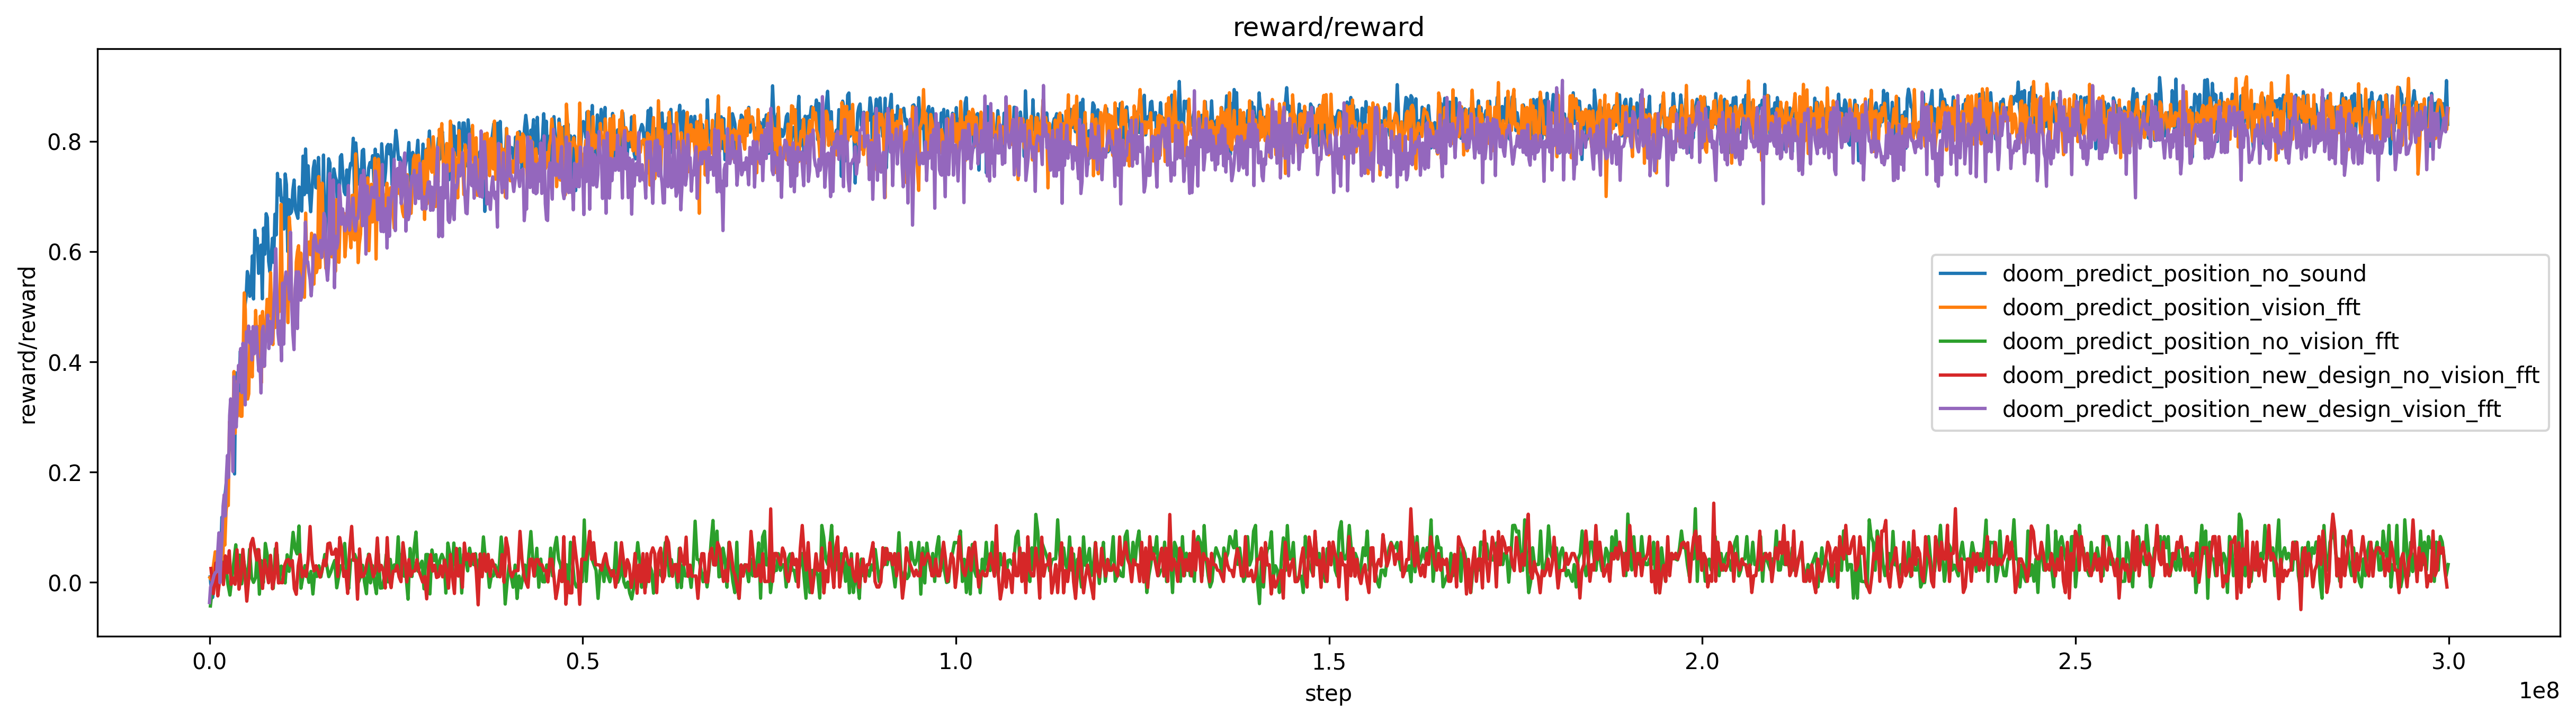

In [ ]:
doom_predict_position_no_sound = tflog2pandas('train_dir_A100/train_dir/doom_predict_position_no_sound/default_experiment/.summary/0/events.out.tfevents.1740950208.DL-Station')
doom_predict_position_vision_fft = tflog2pandas('train_dir_A100/train_dir/doom_predict_position_vision_fft/default_experiment/.summary/0/events.out.tfevents.1740950243.DL-Station')
doom_predict_position_no_vision_fft = tflog2pandas('train_dir_A100/train_dir/doom_predict_position_no_vision_fft/default_experiment/.summary/0/events.out.tfevents.1740950261.DL-Station')
#doom_predict_position_no_vision_fft_auto_aim = tflog2pandas('train_dir_A100/train_dir/doom_predict_position_no_vision_fft_auto_aim/default_experiment/.summary/0/events.out.tfevents.1740950273.DL-Station')
#doom_predict_position_no_vision_fft_sonic_aim = tflog2pandas('train_dir_A100/train_dir/doom_predict_position_no_vision_fft_sonic_aim/default_experiment/.summary/0/events.out.tfevents.1740950288.DL-Station')

doom_predict_position_new_design_no_vision_fft = tflog2pandas('train_dir_A100/train_dir/doom_predict_position_new_design_no_vision_fft/default_experiment/.summary/0/events.out.tfevents.1741141686.DL-Station')
doom_predict_position_new_design_vision_fft = tflog2pandas('train_dir_A100/train_dir/doom_predict_position_new_design_vision_fft/default_experiment/.summary/0/events.out.tfevents.1741141671.DL-Station')
#doom_predict_position_new_design_no_vision_fft_auto_aim = tflog2pandas('train_dir_A100/train_dir/doom_predict_position_new_design_no_vision_fft_auto_aim/default_experiment/.summary/0/events.out.tfevents.1741141696.DL-Station')
#doom_predict_position_new_design_no_vision_fft_sonic_aim = tflog2pandas('train_dir_A100/train_dir/doom_predict_position_new_design_no_vision_fft_sonic_aim/default_experiment/.summary/0/events.out.tfevents.1741141706.DL-Station')

doom_predict_position = {
    #'doom_predict_position_no_sound': doom_predict_position_no_sound,
    #'doom_predict_position_vision_fft': doom_predict_position_vision_fft,
    'doom_predict_position_no_vision_fft': doom_predict_position_no_vision_fft,
    #'doom_predict_position_no_vision_fft_auto_aim': doom_predict_position_no_vision_fft_auto_aim,
    #'doom_predict_position_no_vision_fft_sonic_aim': doom_predict_position_no_vision_fft_sonic_aim,
    'doom_predict_position_new_design_no_vision_fft': doom_predict_position_new_design_no_vision_fft,
    #'doom_predict_position_new_design_vision_fft': doom_predict_position_new_design_vision_fft,
    #'doom_predict_position_new_design_no_vision_fft_auto_aim': doom_predict_position_new_design_no_vision_fft_auto_aim,
    #'doom_predict_position_new_design_no_vision_fft_sonic_aim': doom_predict_position_new_design_no_vision_fft_sonic_aim
}
plot(doom_predict_position, "reward/reward", lim=3e8)

doom_predict_position_no_vision_fft
doom_predict_position_new_design_no_vision_fft


<Figure size 640x480 with 0 Axes>

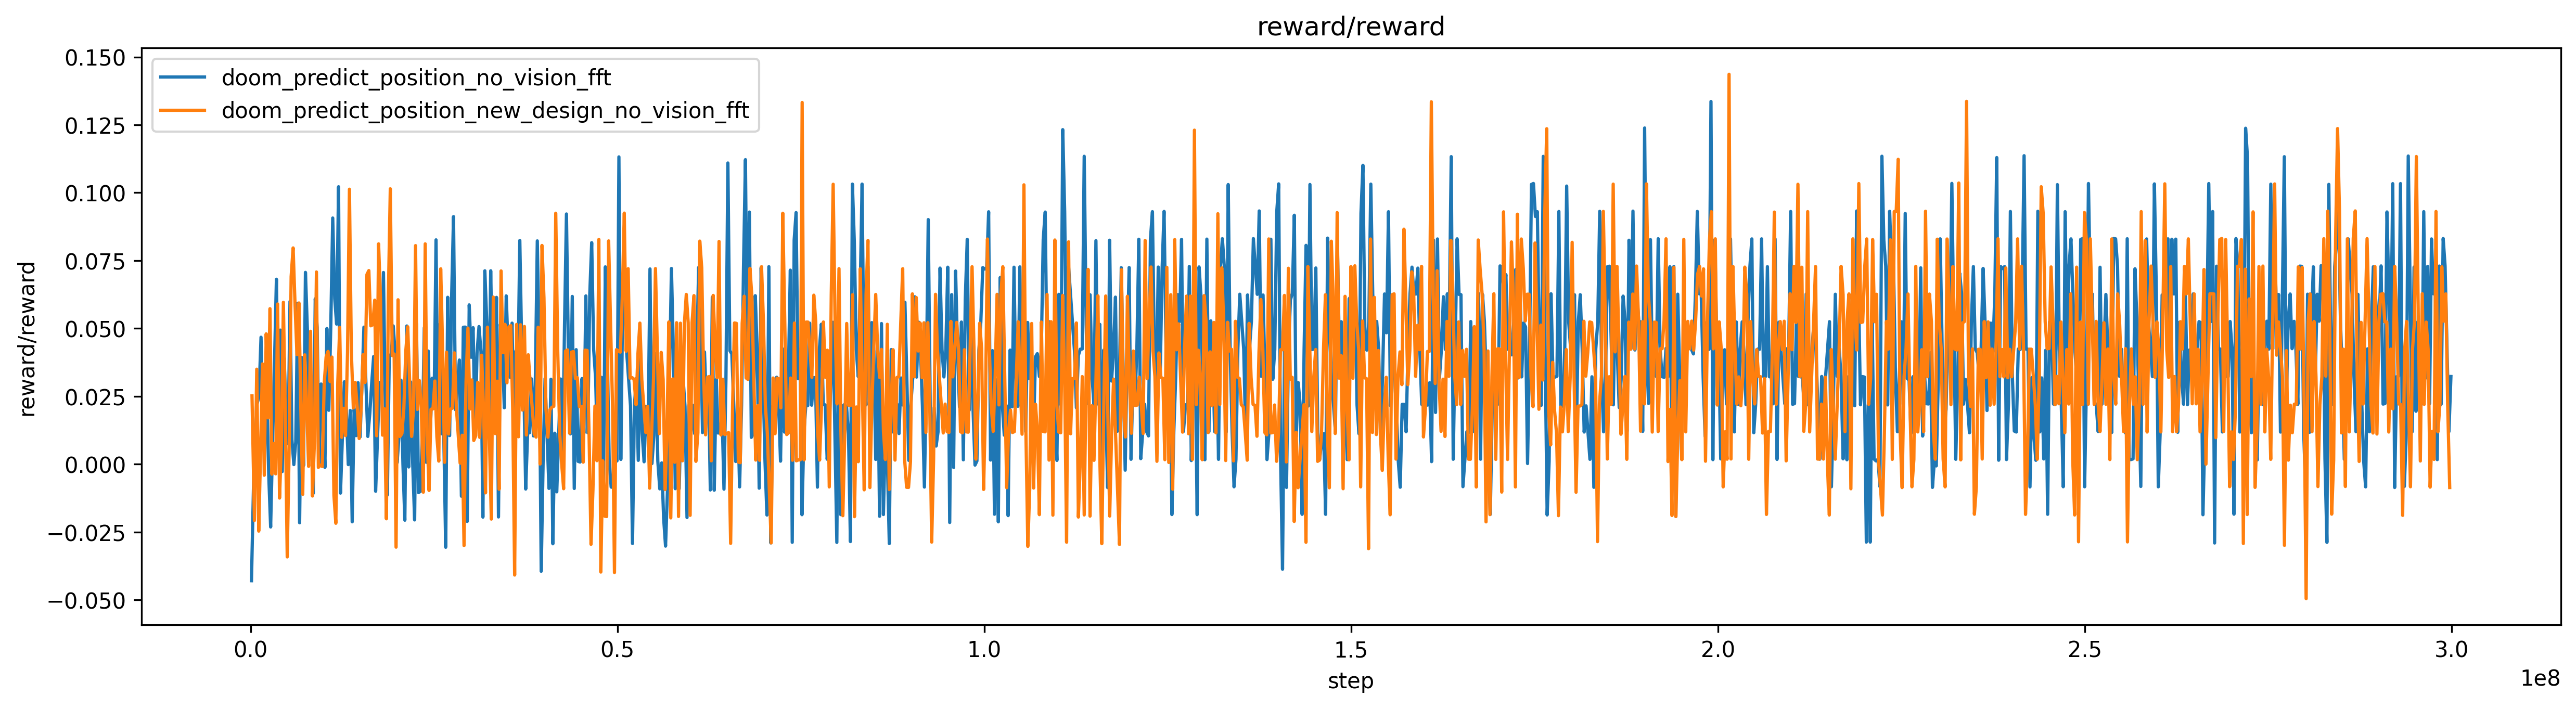

In [62]:
doom_predict_position = {
    #'doom_predict_position_no_sound': doom_predict_position_no_sound,
    #'doom_predict_position_vision_fft': doom_predict_position_vision_fft,
    'doom_predict_position_no_vision_fft': doom_predict_position_no_vision_fft,
    #'doom_predict_position_no_vision_fft_auto_aim': doom_predict_position_no_vision_fft_auto_aim,
    #'doom_predict_position_no_vision_fft_sonic_aim': doom_predict_position_no_vision_fft_sonic_aim,
    'doom_predict_position_new_design_no_vision_fft': doom_predict_position_new_design_no_vision_fft,
    #'doom_predict_position_new_design_vision_fft': doom_predict_position_new_design_vision_fft,
    #'doom_predict_position_new_design_no_vision_fft_auto_aim': doom_predict_position_new_design_no_vision_fft_auto_aim,
    #'doom_predict_position_new_design_no_vision_fft_sonic_aim': doom_predict_position_new_design_no_vision_fft_sonic_aim
}
plot(doom_predict_position, "reward/reward", lim=3e8)

doom_take_cover_no_sound
doom_take_cover_vision_fft
doom_take_cover_no_vision_fft
doom_take_cover_new_design_vision_fft
doom_take_cover_new_design_no_vision_fft


<Figure size 640x480 with 0 Axes>

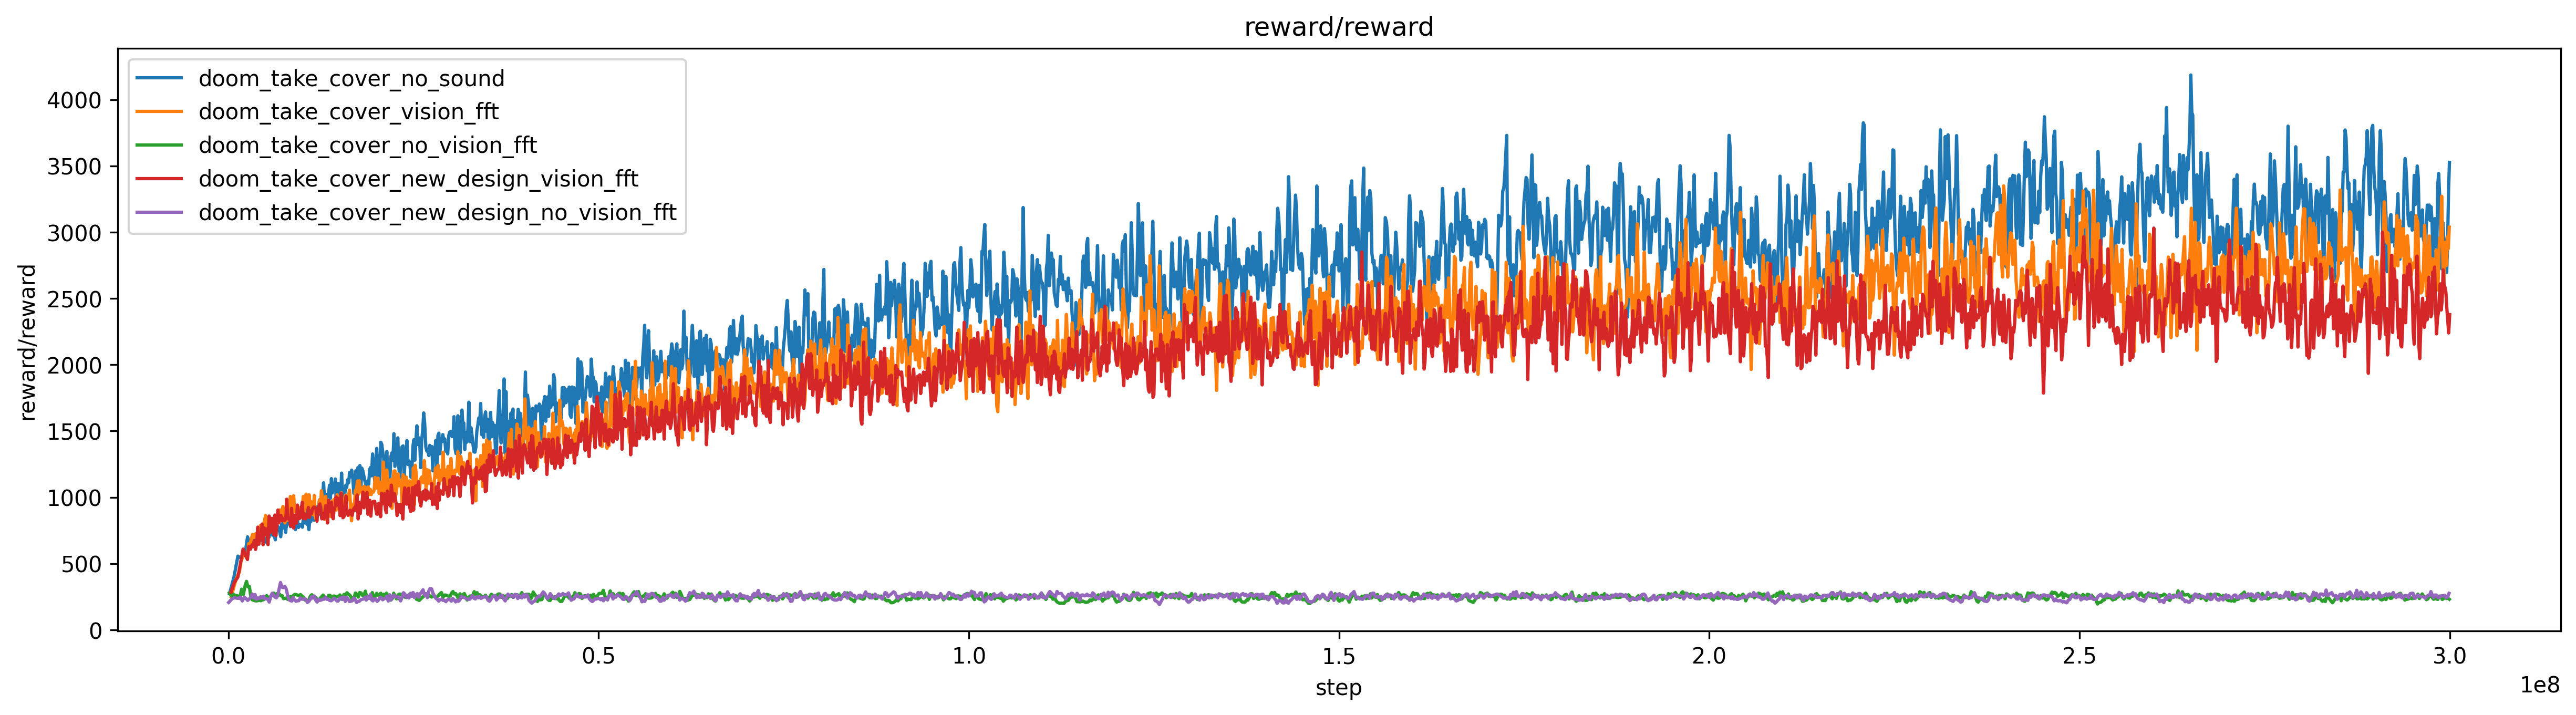

In [64]:
doom_take_cover_no_sound = tflog2pandas('train_dir_a6000/train_dir/doom_take_cover_no_sound/default_experiment/.summary/0/events.out.tfevents.1741011437.localhost-0.tail5e8f5.ts.net')
doom_take_cover_vision_fft = tflog2pandas('train_dir_a6000/train_dir/doom_take_cover_vision_fft/default_experiment/.summary/0/events.out.tfevents.1741011461.localhost-0.tail5e8f5.ts.net')
doom_take_cover_no_vision_fft = tflog2pandas('train_dir_a6000/train_dir/doom_take_cover_no_vision_fft/default_experiment/.summary/0/events.out.tfevents.1741011492.localhost-0.tail5e8f5.ts.net')
#doom_take_cover_no_vision_fft_auto_aim = tflog2pandas('train_dir_a6000/train_dir/doom_take_cover_no_vision_fft_auto_aim/default_experiment/.summary/0/events.out.tfevents.1741011519.localhost-0.tail5e8f5.ts.net')
#doom_take_cover_no_vision_fft_sonic_aim = tflog2pandas('train_dir_a6000/train_dir/doom_take_cover_no_vision_fft_sonic_aim/default_experiment/.summary/0/events.out.tfevents.1741011538.localhost-0.tail5e8f5.ts.net')
doom_take_cover_new_design_vision_fft = tflog2pandas('train_dir_a6000/train_dir/doom_take_cover_new_design_vision_fft/default_experiment/.summary/0/events.out.tfevents.1741097891.localhost-0.tail5e8f5.ts.net')
doom_take_cover_new_design_no_vision_fft = tflog2pandas('train_dir_a6000/train_dir/doom_take_cover_new_design_no_vision_fft/default_experiment/.summary/0/events.out.tfevents.1741097939.localhost-0.tail5e8f5.ts.net')
#doom_take_cover_new_design_no_vision_fft_sonic_aim = tflog2pandas('train_dir_a6000/train_dir/doom_take_cover_new_design_no_vision_fft_sonic_aim/default_experiment/.summary/0/events.out.tfevents.1741098009.localhost-0.tail5e8f5.ts.net')
#doom_take_cover_new_design_no_vision_fft_auto_aim = tflog2pandas('train_dir_a6000/train_dir/doom_take_cover_new_design_no_vision_fft_auto_aim/default_experiment/.summary/0/events.out.tfevents.1741097974.localhost-0.tail5e8f5.ts.net')

doom_take_cover = {
    'doom_take_cover_no_sound': doom_take_cover_no_sound,
    'doom_take_cover_vision_fft': doom_take_cover_vision_fft,
    'doom_take_cover_no_vision_fft': doom_take_cover_no_vision_fft,
    #'doom_take_cover_no_vision_fft_auto_aim': doom_take_cover_no_vision_fft_auto_aim,
    #'doom_take_cover_no_vision_fft_sonic_aim': doom_take_cover_no_vision_fft_sonic_aim,
    'doom_take_cover_new_design_vision_fft': doom_take_cover_new_design_vision_fft,
    'doom_take_cover_new_design_no_vision_fft': doom_take_cover_new_design_no_vision_fft,
    #'doom_take_cover_new_design_no_vision_fft_sonic_aim': doom_take_cover_new_design_no_vision_fft_sonic_aim,
    #'doom_take_cover_new_design_no_vision_fft_auto_aim': doom_take_cover_new_design_no_vision_fft_auto_aim,
}
plot(doom_take_cover, "reward/reward", lim=3e8)

doom_take_cover_vision_fft
doom_take_cover_new_design_vision_fft


<Figure size 640x480 with 0 Axes>

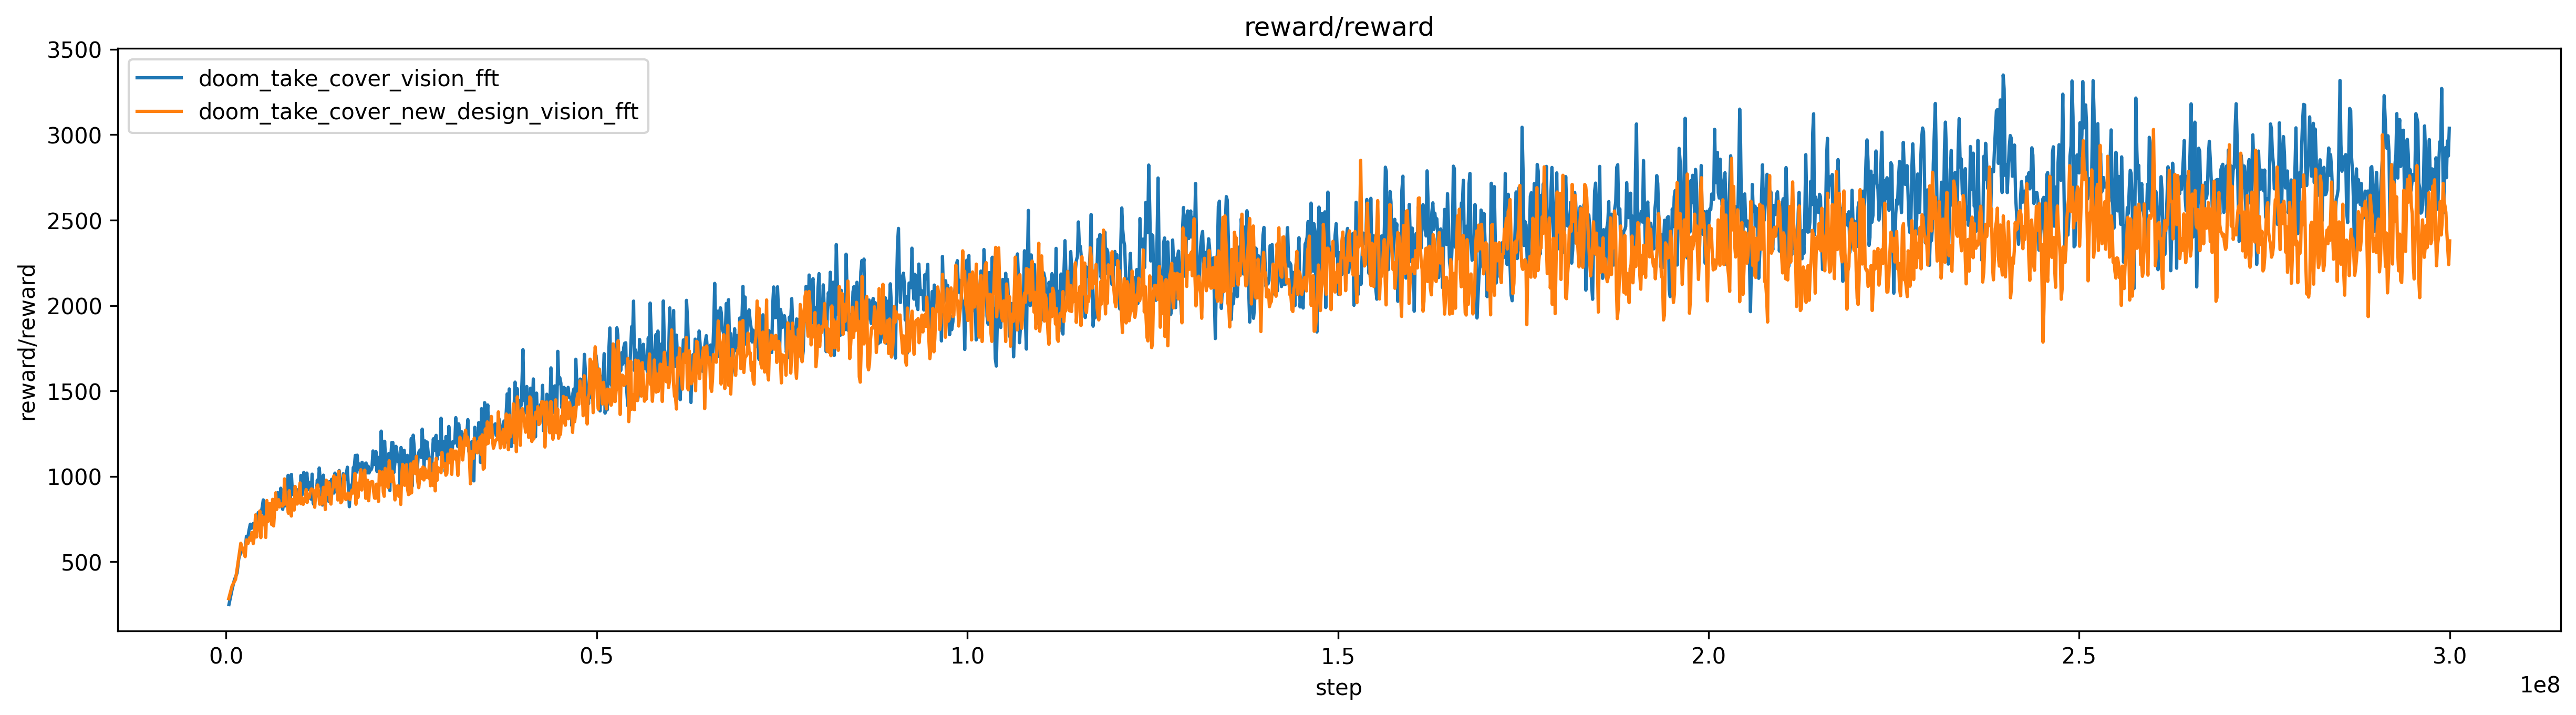

In [66]:
doom_take_cover = {
    #'doom_take_cover_no_sound': doom_take_cover_no_sound,
    'doom_take_cover_vision_fft': doom_take_cover_vision_fft,
    #'doom_take_cover_no_vision_fft': doom_take_cover_no_vision_fft,
    #'doom_take_cover_no_vision_fft_auto_aim': doom_take_cover_no_vision_fft_auto_aim,
    #'doom_take_cover_no_vision_fft_sonic_aim': doom_take_cover_no_vision_fft_sonic_aim,
    'doom_take_cover_new_design_vision_fft': doom_take_cover_new_design_vision_fft,
    #'doom_take_cover_new_design_no_vision_fft': doom_take_cover_new_design_no_vision_fft,
    #'doom_take_cover_new_design_no_vision_fft_sonic_aim': doom_take_cover_new_design_no_vision_fft_sonic_aim,
    #'doom_take_cover_new_design_no_vision_fft_auto_aim': doom_take_cover_new_design_no_vision_fft_auto_aim,
}
plot(doom_take_cover, "reward/reward", lim=3e8)

In [74]:
exponential_moving_average([1, 2, 3, 5, 8, 13, 21])

[0.625,
 1.3265306122448979,
 2.0955882352941178,
 3.3553088133240805,
 5.304108485499463,
 8.471121177802944,
 13.56828549408432]